In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer , MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer # Required for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor 
import warnings; warnings.simplefilter('ignore')



تحميل البيانات 

تحديد العمود المستهدف للتنبؤ ('price').
تقسم البيانات إلى:

X: ميزات الإدخال 

y: الهدف


 تقسيم البيانات للتدريب والتحقق 


x_train, y_train: 80% من البيانات ستستخدم لتدريب النموذج

x_val, y_val: 20% من البيانات ستستخدم للتحقق من أداء النموذج على بيانات


تم استخدام اللوغارتيم  من اجل أن
يقلل من تأثير القيم الشاذة (outliers)


In [2]:
df = pd.read_csv("train.csv")
target_col = ['price']
X = df.drop(target_col,axis=1)
y = df[target_col]

x_train, x_val , y_train , y_val = train_test_split(X,y,test_size=0.2, random_state=42)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

عرض عدد الاعمدة وعدد الصفوف 
واسماء الاعمدة (الفيتشرز)

In [3]:
print(x_train.shape)     
print(x_train.columns)   


(213060, 16)
Index(['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating', 'sale_month',
       'sale_year'],
      dtype='object')


In [4]:
x_train.head()

,ID,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,sale_month,sale_year
62556,62556,"Flat 6, 7 De Crespigny Park, London, SE5 8AB",SE5 8AB,England,SE5,51.470484,-0.090867,NaN,1.0,52.0,NaN,Leasehold,Flat/Maisonette,D,10,2003
19893,19893,"Flat 3, Felix Studios, 29 Felix Avenue, London...",N8 9TL,England,N8,51.580456,-0.122099,2.0,2.0,79.0,1.0,Leasehold,Converted Flat,F,5,1998
197684,197684,"Flat 35, Shelley House, London, SW1V 3JD",SW1V 3JD,England,SW1V,51.485468,-0.139674,1.0,1.0,42.0,1.0,Leasehold,Purpose Built Flat,E,6,2021
149641,149641,"7 William Brown Court, Norwood Road, London, S...",SE27 9DD,England,SE27,51.437576,-0.105073,1.0,3.0,102.0,1.0,Leasehold,Purpose Built Flat,NaN,9,2016
133936,133936,"21C Deronda Road, London, SE24 9BQ",SE24 9BQ,England,SE24,51.444199,-0.106454,1.0,2.0,66.0,1.0,Leasehold,Purpose Built Flat,C,10,2014


In [5]:

print(x_train['outcode'].describe())
print(x_train['outcode'].value_counts().index.to_list())

count     213060
unique       167
top         SE18
freq        3626
Name: outcode, dtype: object
['SE18', 'SW2', 'N16', 'SW4', 'SW16', 'SE9', 'SE6', 'N22', 'N17', 'E17', 'W4', 'SE23', 'N15', 'SE12', 'SE3', 'SW9', 'SW13', 'SE13', 'E11', 'SE26', 'N1', 'SE25', 'N8', 'SE1', 'SE19', 'SW14', 'SE4', 'SW12', 'N6', 'SE20', 'N10', 'N4', 'SE27', 'E8', 'SW19', 'E18', 'NW10', 'SE28', 'SW18', 'E9', 'E4', 'SW6', 'E10', 'SE8', 'E1', 'SE7', 'NW1', 'NW6', 'SW17', 'SE5', 'E5', 'SE24', 'SE15', 'SE16', 'SE11', 'SW11', 'SW8', 'SE21', 'NW3', 'SW15', 'W2', 'SW3', 'NW2', 'E2', 'E14', 'SE14', 'SE10', 'SW1V', 'SE2', 'SE22', 'W11', 'E6', 'W6', 'N2', 'W9', 'E7', 'SW7', 'N7', 'NW8', 'W14', 'N12', 'W1H', 'N21', 'W8', 'NW11', 'N11', 'W5', 'NW5', 'E3', 'NW9', 'SW1X', 'E15', 'N14', 'W10', 'E12', 'N19', 'NW7', 'SW20', 'N5', 'N13', 'N9', 'W13', 'SW5', 'W12', 'W3', 'NW4', 'SW10', 'SW1P', 'WC1H', 'E16', 'SE17', 'E13', 'SW1W', 'W7', 'N3', 'W1U', 'EC2Y', 'N20', 'N18', 'EC1R', 'W1W', 'EC1Y', 'W1G', 'EC1V', 'W1J', 'EC1M', 'W1K

عرض عدد الصفوف والأعمدة

أسماء الأعمدة

عدد القيم غير الفارغة لكل عمود

نوع البيانات لكل عمود ص

حجم الذاكرة المستهلكة

In [7]:
x_train.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 213060 entries, 62556 to 121958
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   213060 non-null  int64  
 1   fullAddress          213060 non-null  object 
 2   postcode             213060 non-null  object 
 3   country              213060 non-null  object 
 4   outcode              213060 non-null  object 
 5   latitude             213060 non-null  float64
 6   longitude            213060 non-null  float64
 7   bathrooms            174274 non-null  float64
 8   bedrooms             193127 non-null  float64
 9   floorAreaSqM         202050 non-null  float64
 10  livingRooms          183377 non-null  float64
 11  tenure               208491 non-null  object 
 12  propertyType         212643 non-null  object 
 13  currentEnergyRating  167575 non-null  object 
 14  sale_month           213060 non-null  int64  
 15  sale_year         

استخراج عدد القيم المفقودة من الاعمدة 
حيث يظهر انه هناك 7 اعمدة فيها قيم مفقودة 


In [8]:
x_train.isnull().sum() 

ID                         0
fullAddress                0
postcode                   0
country                    0
outcode                    0
latitude                   0
longitude                  0
bathrooms              38786
bedrooms               19933
floorAreaSqM           11010
livingRooms            29683
tenure                  4569
propertyType             417
currentEnergyRating    45485
sale_month                 0
sale_year                  0
dtype: int64

## Mouaz

## تحليل إحصائي للوصف العددي لبعض المتغيرات

### 1. (bathrooms)
- **القيم الاعلى:** `max = 9.0`
- **الربع الأول (25%) والوسيط (50%) = 1.0**
- **التحليل:**  
  ربع العقارات أو أكثر لديها حمام واحد فقط.
- **طبيعة التوزيع:**  
  التوزيع **منحرف إيجابًا (Right-skewed)** أن معظم العقارات تحتوي على عدد قليل من الحمامات بينما القليل جدًا يحتوي على عدد كبير 

---

### 2. (bedrooms)
- **المتوسط:** `2.496`  
- **الوسيط (50%) = 2.0**
- **الربع الأول (25%) = 2.0**
- **التحليل:**  
  المتوسط أعلى  من الوسيط.
- **طبيعة التوزيع:**  
  يشبه توزيع الحمامات فهو أيضًا **منحرف إيجابًا (Right-skewed)**.  
  معظم العقارات تحتوي على غرفتي نوم أو ثلاث والقليل يحتوي على عدد أكبر (حتى 9 غرف نوم).

---

### 3. (floorAreaSqM)
- **المتوسط:** `99.656`  
- **الوسيط (50%) = 85.0**
- **التحليل:**  
  الفرق الكبير بين المتوسط والوسيط يدل على وجود عقارات ذات مساحات كبيرة جدا تؤثر على المتوسط.
- **طبيعة التوزيع:**  
  **منحرف إيجابًا  ( Right-skewed)**.  
  معظم العقارات مساحتها صغيرة أو متوسطة مع وجود عدد قليل جدا من العقارات ذات المساحات الكبيرة جدا.

---

### 4. (livingRooms)
- **المتوسط:** `1.292`  
- **الوسيط (50%) = 1.0**
- **الربعي الأول (25%) = 1.0**  
- **الربعي الثالث (75%) = 1.0**
- **التحليل:**  
  القيم كلها تشير إلى وجود غرفة معيشة واحدة في أغلب العقارات
- **طبيعة التوزيع:**  
  **منحرف إيجابًا  ( Right-skewed)** حيث أن الغالبية العظمى من العقارات لديها غرفة معيشة واحدة فقط


In [77]:
x_train.describe()  

,ID,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,sale_month,sale_year
count,213060.000000,213060.000000,213060.000000,174274.000000,193127.000000,202050.000000,183377.000000,213060.000000,213060.000000
mean,133049.967971,51.510100,-0.104618,1.439251,2.496290,99.656412,1.292730,6.802229,2012.200493
std,76888.995080,0.056691,0.088170,0.721012,1.171409,56.480051,0.584022,3.358366,9.145104
min,0.000000,51.385708,-0.347055,1.000000,1.000000,10.000000,1.000000,1.000000,1995.000000
25%,66437.750000,51.466683,-0.159328,1.000000,2.000000,63.000000,1.000000,4.000000,2004.000000
50%,132970.500000,51.507211,-0.108713,1.000000,2.000000,85.000000,1.000000,7.000000,2014.000000
75%,199652.500000,51.550906,-0.049141,2.000000,3.000000,118.000000,1.000000,10.000000,2021.000000
max,266323.000000,51.665823,0.139249,9.000000,9.000000,500.000000,9.000000,12.000000,2023.000000


## رسم الانحرافات والتوزيعات بعد التحليل الإحصائي


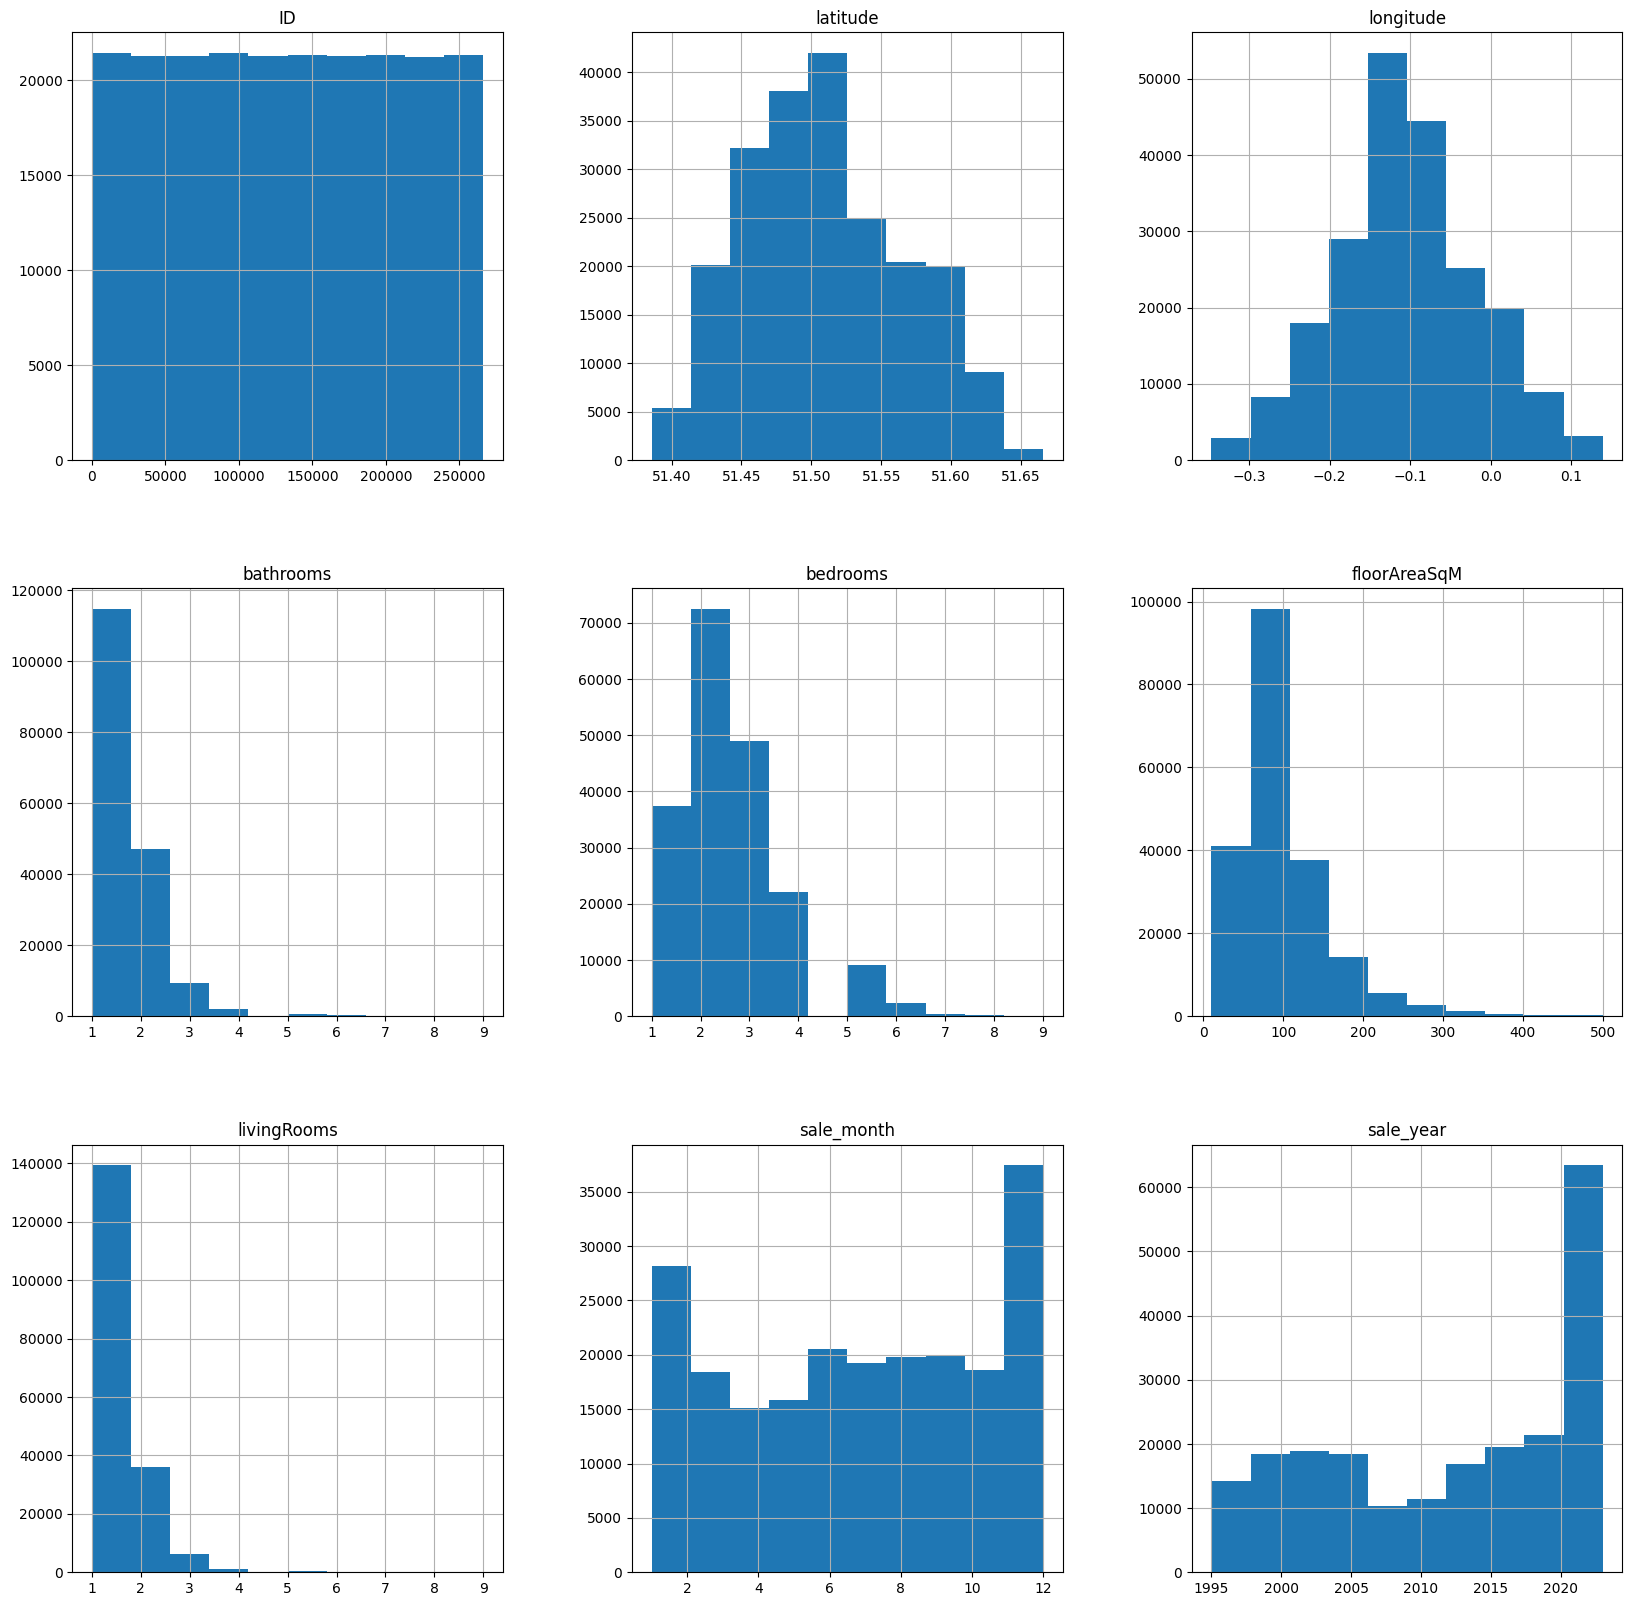

In [22]:
x_train.hist(figsize=(20, 20))
plt.show()

## Kenana

###  التحويل اللوغاريتمي

- **مقارنة المتوسط والوسيط:**
  - المتوسط = `12.84`  
  - الوسيط = `12.86`

- **التحليل:**
  - القرب الشديد بين المتوسط والوسيط يشير إلى أن التوزيع أصبح أكثر **تقارب**.
  - هذا يدل على أن **التحويل اللوغاريتمي**  `np.log1p` قد نجح في **تقليل الانحراف** وجعل توزيع متغير السعر أقرب إلى التوزيع الطبيعي.
  - من المحتمل أن التوزيع كان **منحرفًا كثيرا**.


In [23]:
y_train_log.describe()


,price
count,213060.000000
mean,12.839568
std,0.928867
min,9.210440
25%,12.283038
50%,12.861001
75%,13.384729
max,18.420681


<Axes: ylabel='Count'>

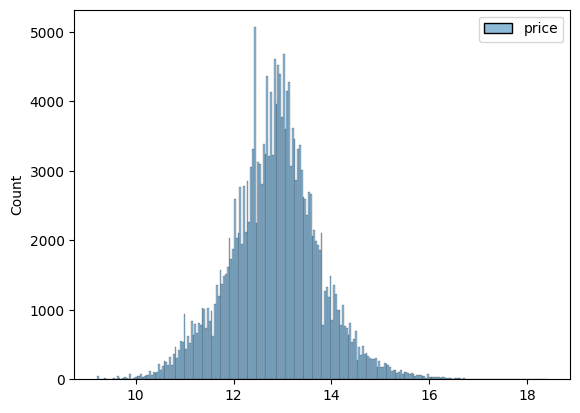

In [24]:
sns.histplot(y_train_log)

<Axes: >

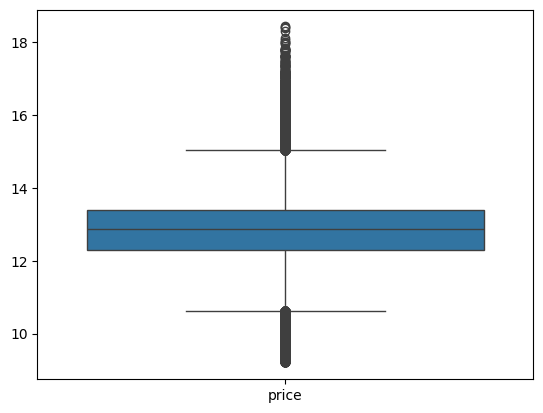

In [25]:
sns.boxplot(y_train_log)

## Kenana

###   الأعمدة الفئوية

يتم البحث داخل مجموعة البيانات `X` عن الأعمدة التي تحتوي على نوع البيانات `category`.  
هذه الأعمدة تمثل  الصفات غير الرقمية مثل:
- أسماء المدن  
- أنواع العقارات  

أسماء هذه الأعمدة يتم حفظها في المتغير `categorical_cols`  ليتم التعامل معها  في التحليل أو المعالجة


In [26]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print()

--- fullAddress ---
fullAddress
74 Western Beach Apartments, 36 Hanover Avenue, London, E16 1DZ            112
Clarendon Court, 2 Brackley Street, London, EC1Y 0AB                        84
Oak Apple Court, Gables Close, London, SE12 0UB                             75
Horley Court, 46 Inverness Terrace, London, W2 3JA                          68
6, 14–16 Church Hill, London, E17 3AG                                       59
                                                                          ... 
1 Mylne Close, London, W6 9TE                                                1
24 St Mary's Court, Stamford Brook Road, London, W6 0XP                      1
Flat 44, Belgravia House Dickens Yard, Longfield Avenue, London, W5 2BE      1
33 Clarendon Road, London, W5 1AA                                            1
6 Park View Road, London, W5 2JB                                             1
Name: count, Length: 118345, dtype: int64

--- postcode ---
postcode
WC2R 1AB    209
SW1P 3AN    17

###  رسم العلاقة بين المتغيرات والسعر

يتم رسم:

- **Scatter Plots** بين كل متغير رقمي والسعر (قبل وبعد التحويل اللوغاريتمي)
- **Box Plots** بين كل متغير فئوي والسعر (قبل وبعد التحويل اللوغاريتمي)



🎯 **الهدف من هذه الرسوم :**

- مقارنة العلاقة بين المتغيرات والسعر بصيغته الأصلية والمحولة
- الكشف عن:
  - الأنماط (Trends)
  - التشتت (Variance)
  - القيم المتطرفة (Outliers)
  - الفروقات بين المجموعات (Group Differences)



Generating plots...


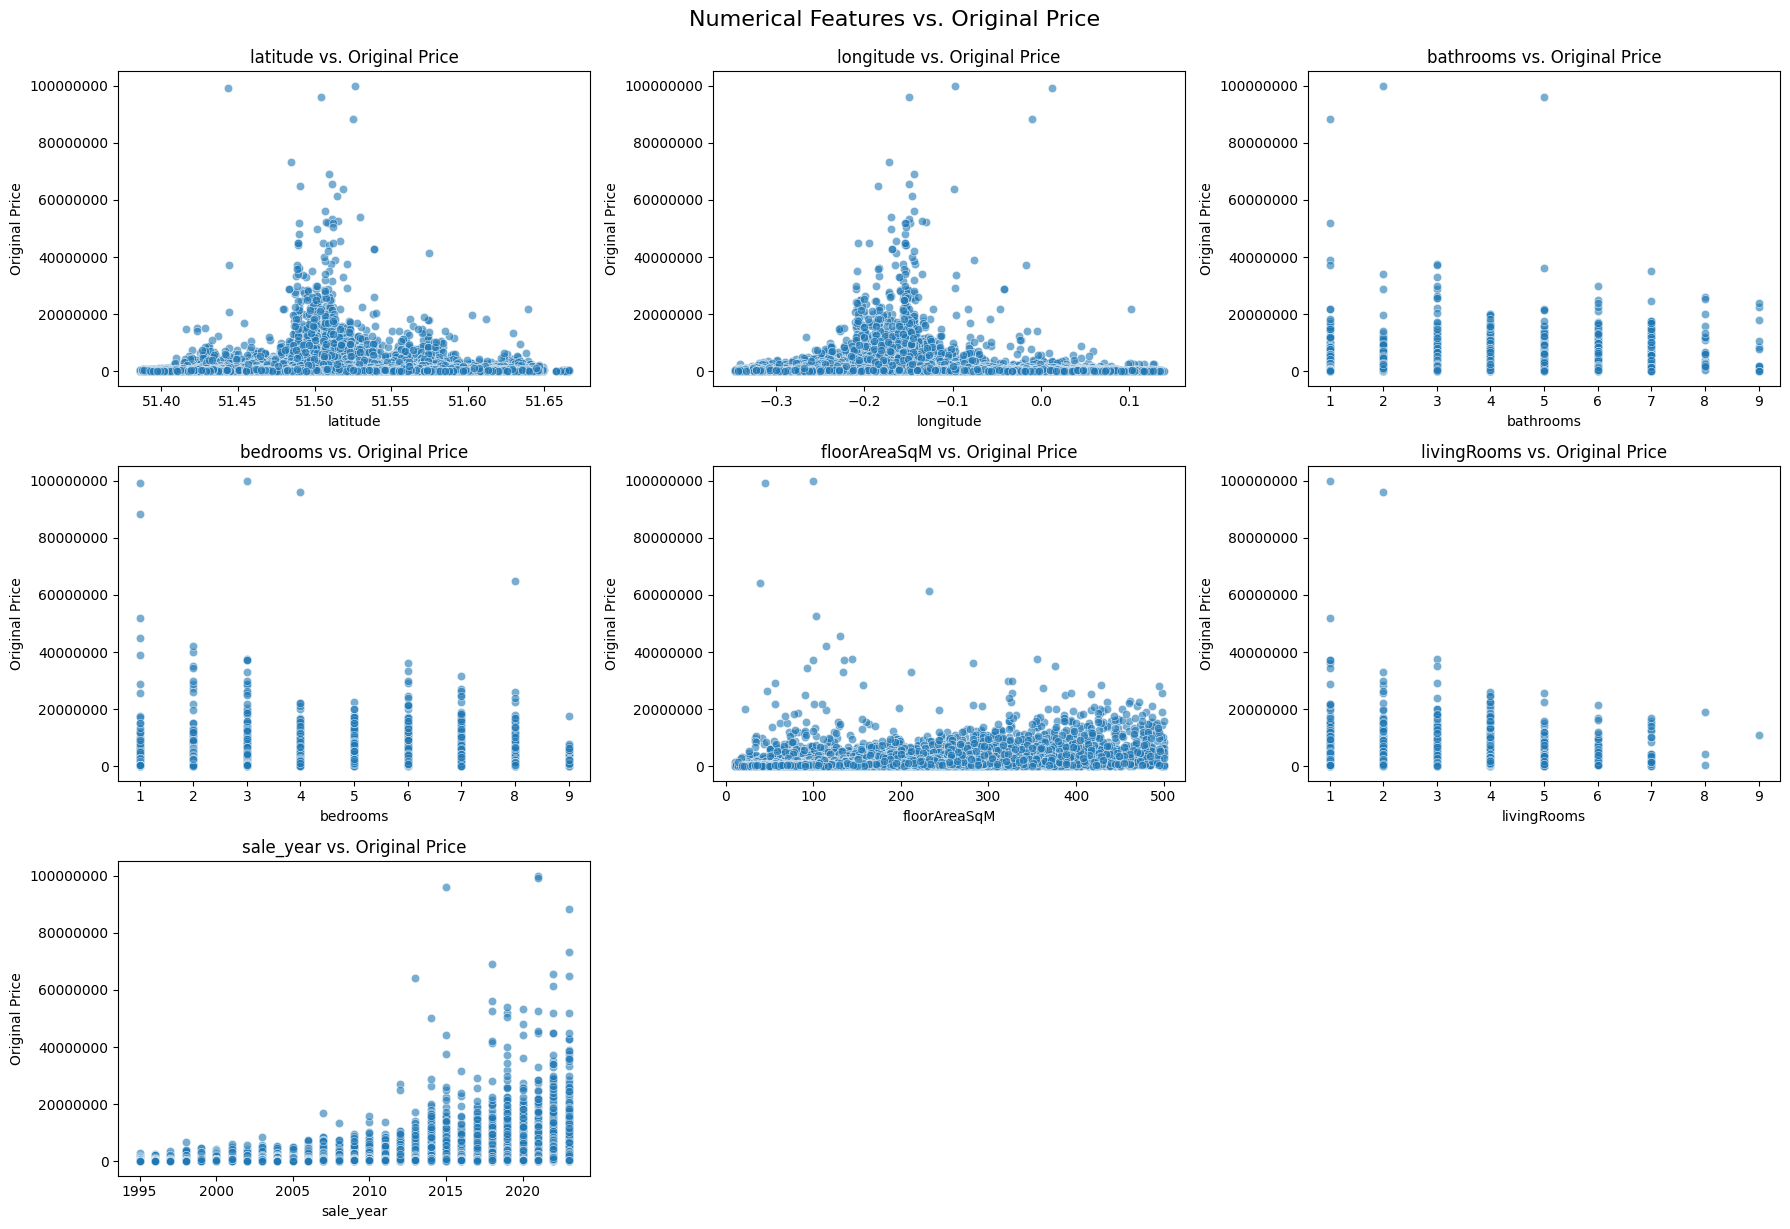

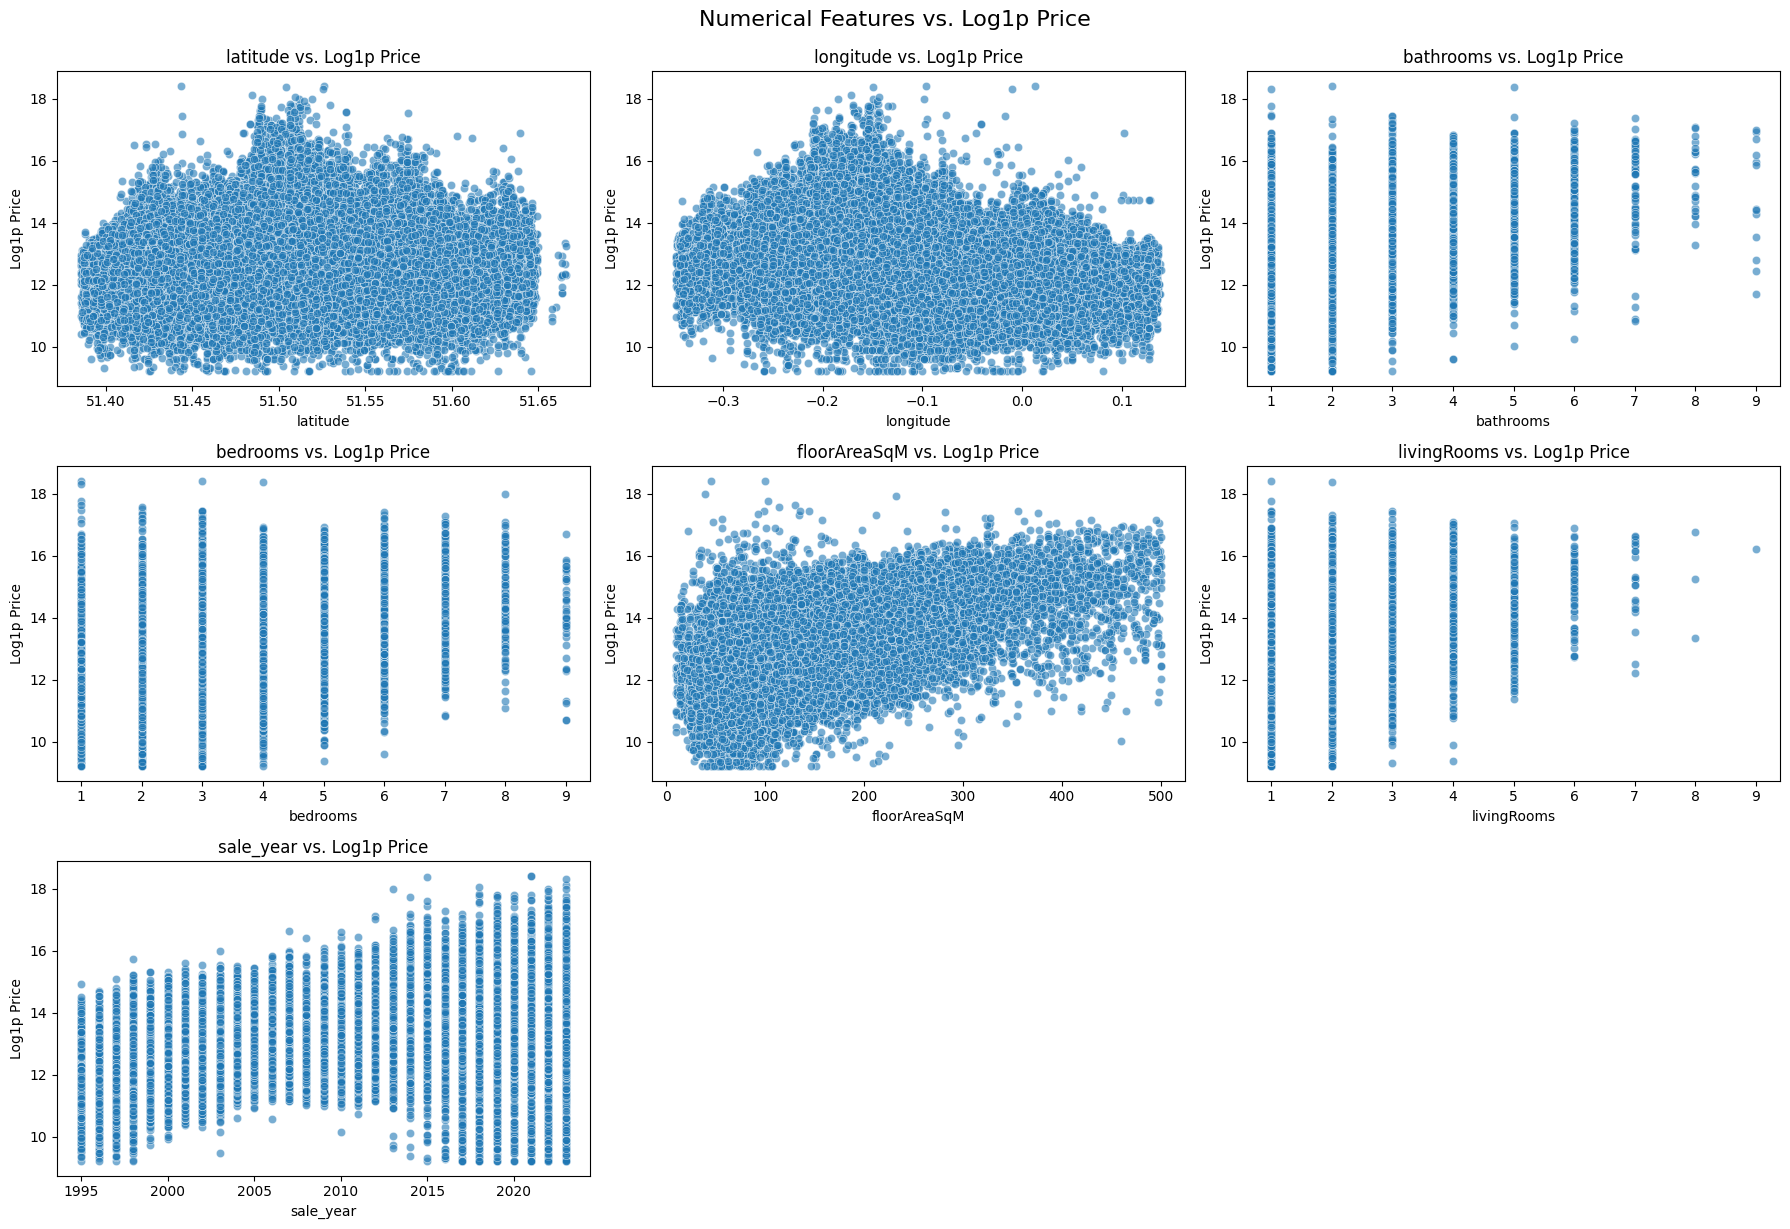

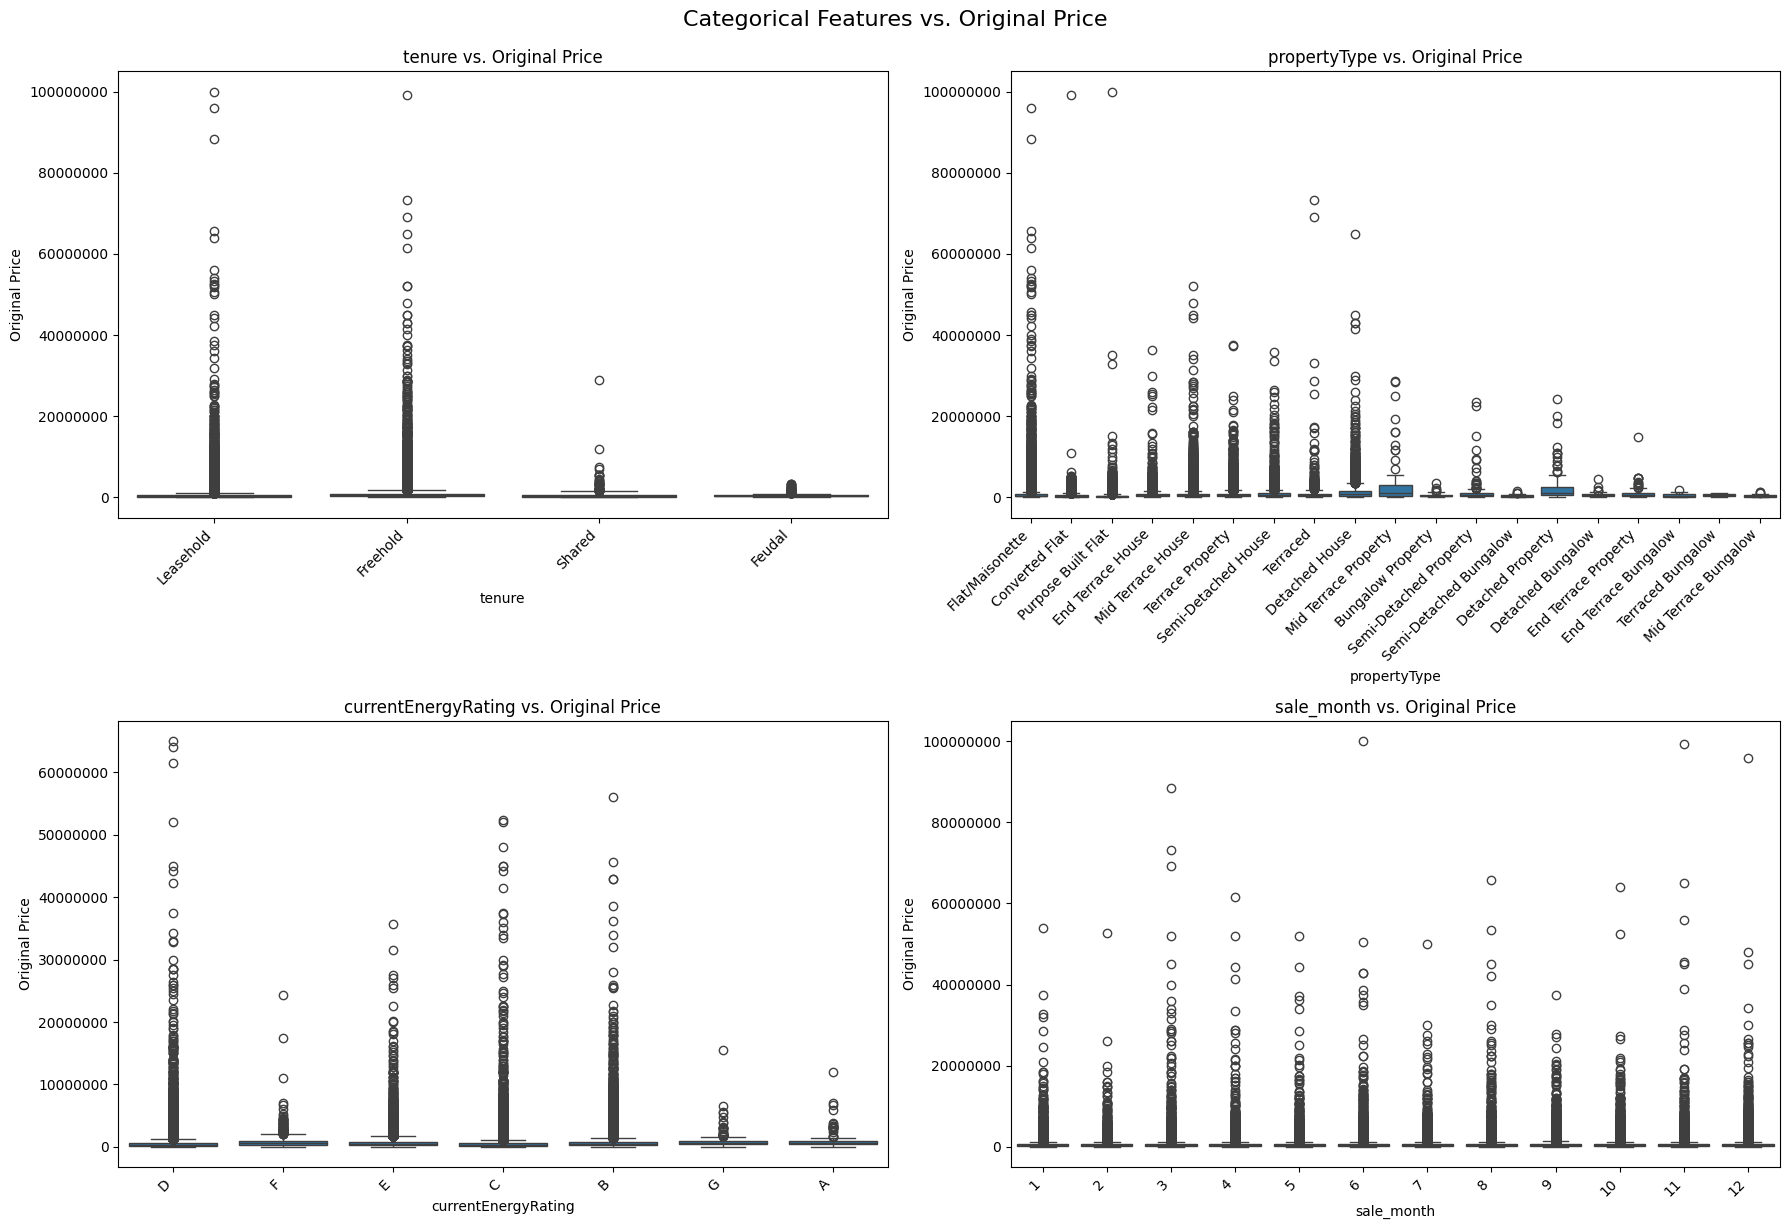

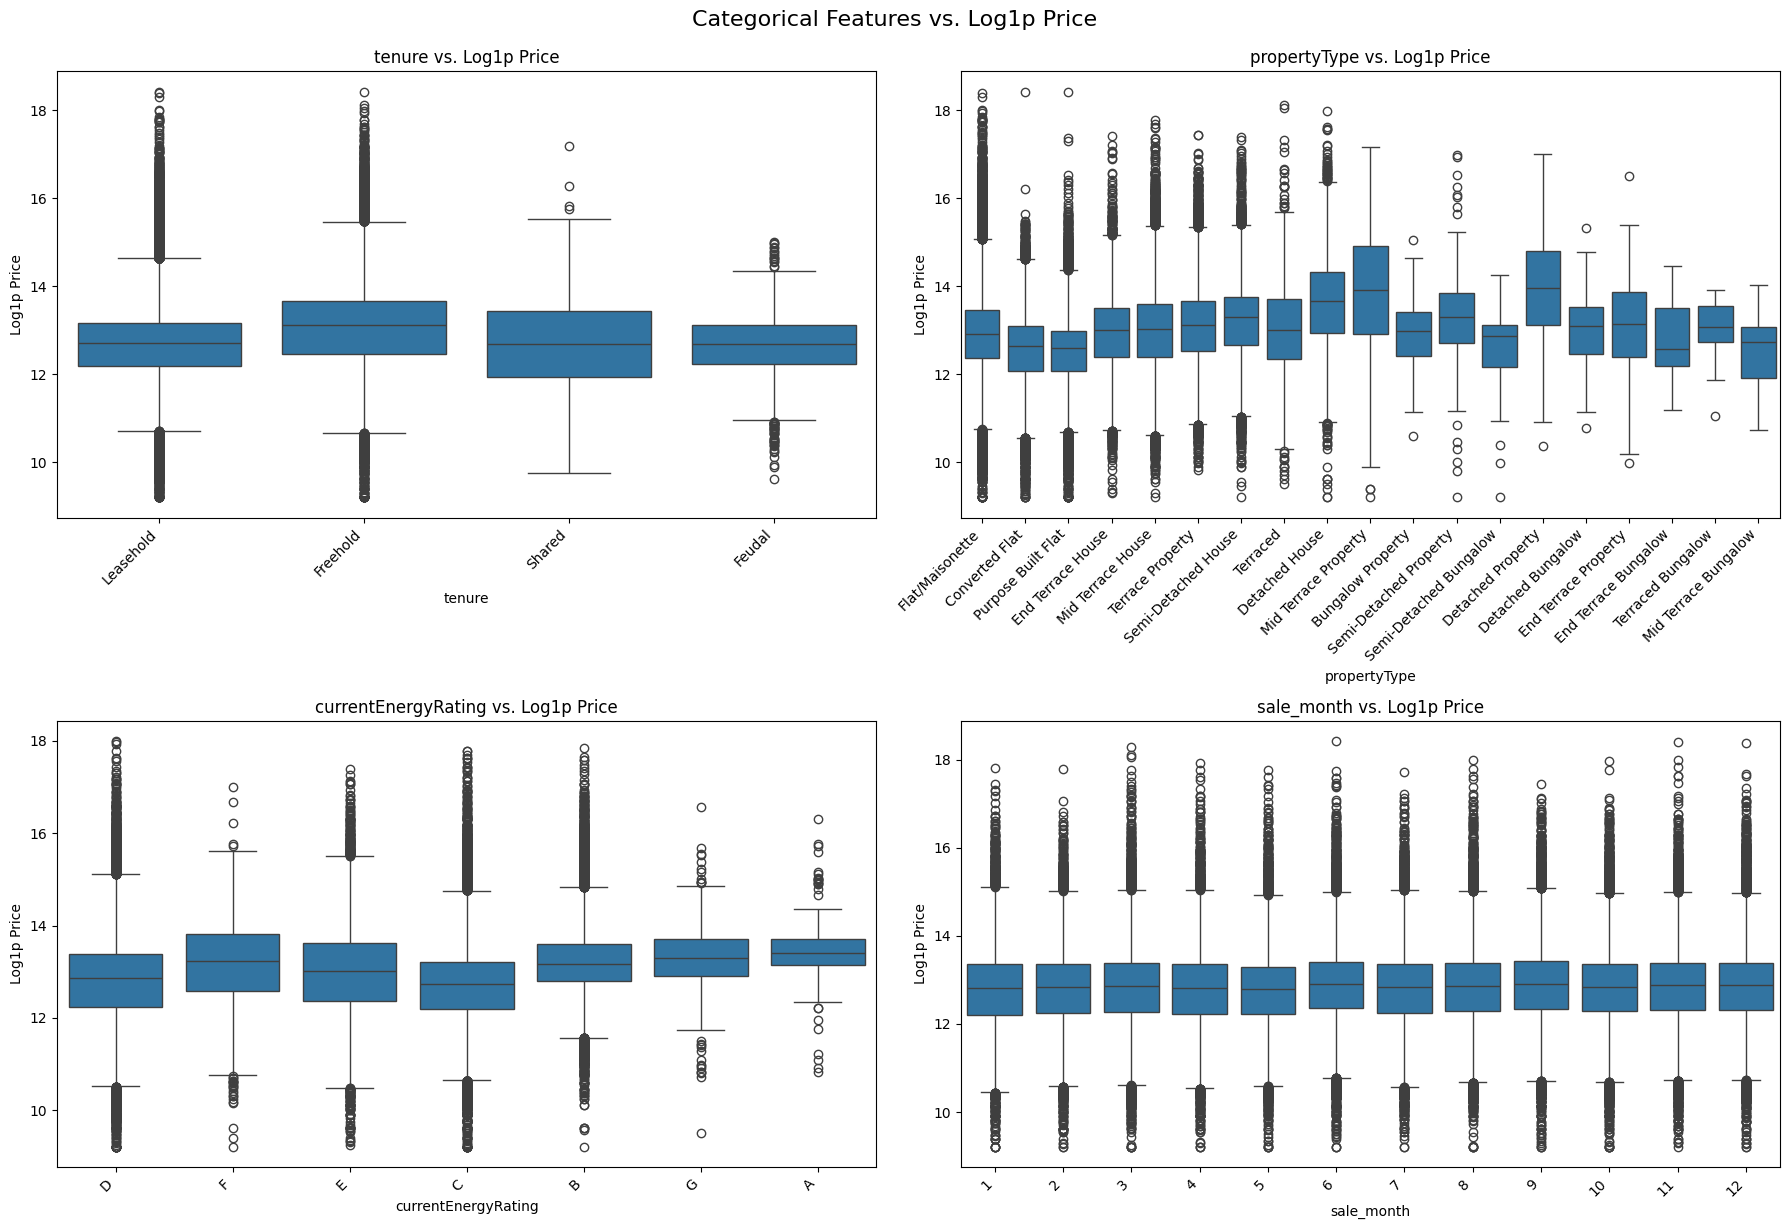


Plots generated. Observe the relationships and how the log1p transformation affects them.
Look for: trends (linear/non-linear), variance, outliers, and group differences.


In [ ]:

df_plot = x_train.copy()
df_plot['price_original'] = y_train
df_plot['price_log1p'] = np.log1p(y_train)



numerical_features = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'sale_year']
categorical_features = ['tenure', 'propertyType', 'currentEnergyRating', 'sale_month']




# --- Plot Numerical Features vs. Price ---
plt.figure(figsize=(18, 12)) 
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1) 
    sns.scatterplot(x=df_plot[col], y=df_plot['price_original'], alpha=0.6)
    plt.title(f'{col} vs. Original Price')
    plt.xlabel(col)
    plt.ylabel('Original Price')
    plt.ticklabel_format(style='plain', axis='y') 

plt.tight_layout()
plt.suptitle('Numerical Features vs. Original Price', y=1.02, fontsize=16) 
plt.show()


plt.figure(figsize=(18, 12)) 
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=df_plot[col], y=df_plot['price_log1p'], alpha=0.6)
    plt.title(f'{col} vs. Log1p Price')
    plt.xlabel(col)
    plt.ylabel('Log1p Price')

plt.tight_layout()
plt.suptitle('Numerical Features vs. Log1p Price', y=1.02, fontsize=16)
plt.show()


# --- Plot Categorical Features vs. Price (Box Plots) ---
plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1) 
    sns.boxplot(x=df_plot[col], y=df_plot['price_original'])
    plt.title(f'{col} vs. Original Price')
    plt.xlabel(col)
    plt.ylabel('Original Price')
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.suptitle('Categorical Features vs. Original Price', y=1.02, fontsize=16)
plt.show()


plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df_plot[col], y=df_plot['price_log1p'])
    plt.title(f'{col} vs. Log1p Price')
    plt.xlabel(col)
    plt.ylabel('Log1p Price')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle('Categorical Features vs. Log1p Price', y=1.02, fontsize=16)
plt.show()



## Ahmad 

###  الرسم

فهم توزيع القيم داخل كل عمود فئوي 
والتعرف على الفئات **الاكثر انتشار** أو **غير المتوازنة** ضمن البيانات


C:\Users\Ahmad Abboud\AppData\Local\Temp\ipykernel_12304\3778944424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette='viridis')


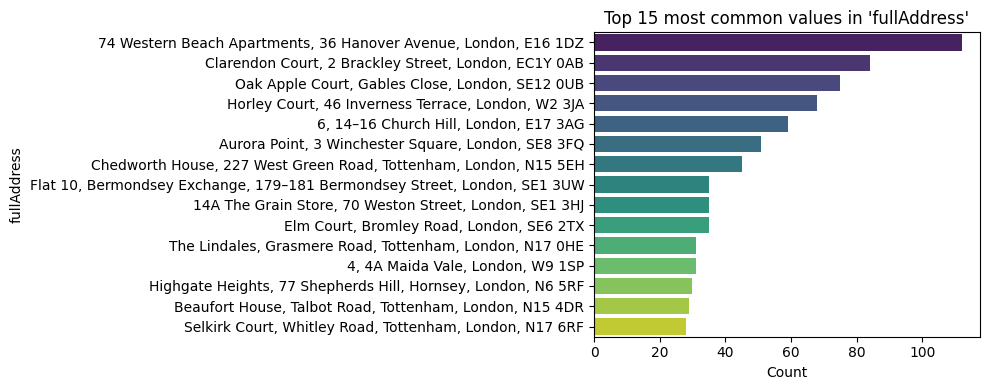

C:\Users\Ahmad Abboud\AppData\Local\Temp\ipykernel_12304\3778944424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette='viridis')


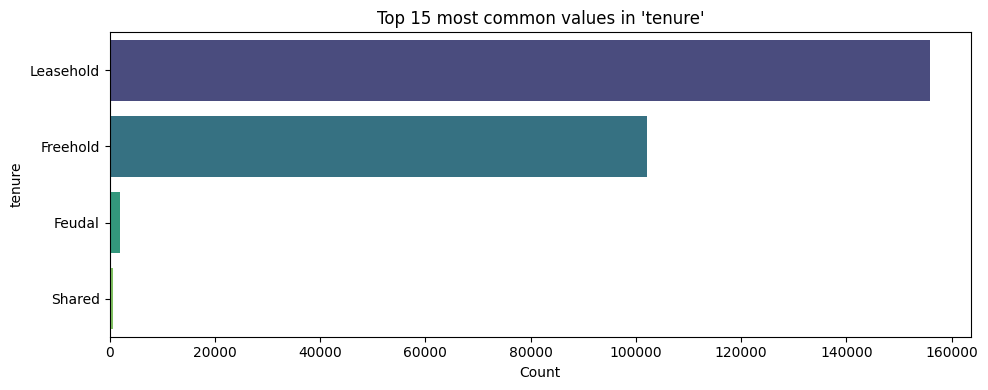

C:\Users\Ahmad Abboud\AppData\Local\Temp\ipykernel_12304\3778944424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette='viridis')


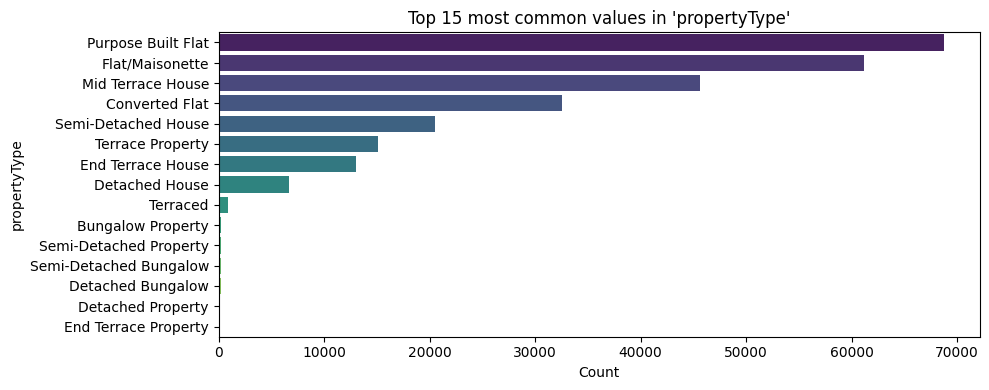

C:\Users\Ahmad Abboud\AppData\Local\Temp\ipykernel_12304\3778944424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette='viridis')


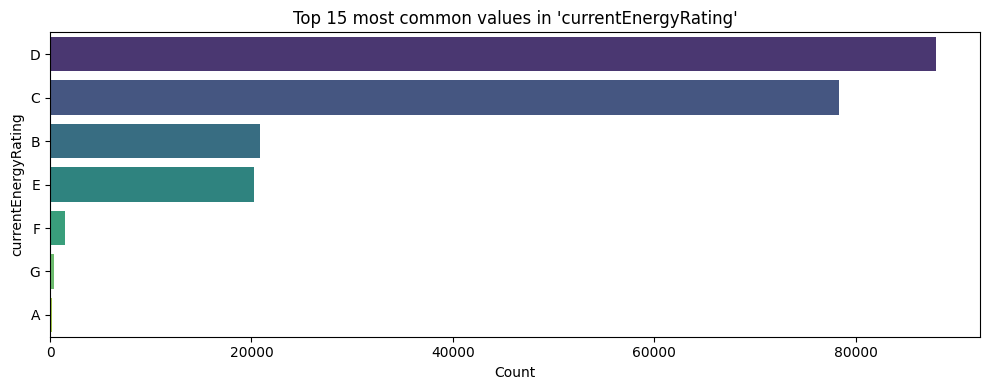

In [ ]:
def plot_top_categories(df, column, top_n=10):
    top_values = df[column].value_counts().nlargest(top_n)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_values.values, y=top_values.index, palette='viridis')
    plt.title(f"Top {top_n} most common values in '{column}'")
    plt.xlabel("Count")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

for col in categorical_cols:    
    plot_top_categories(X, col, top_n=15)
    

## Ahmad & Mouaz

حسب ما حللنا سابقا وحسب هذه النتائج 
- **bathrooms** و **bedrooms** و **floorAreaSqM** مرتبطين ببعضهم بشكل قوي
  مما يعني أن العقار الكبير  يحتوي على عدد أكبر من الحمامات وغرف النوم

- **longitude** مرتبط بشكل سلبي مع  هذه الخصائص، 
  مما يشير إلى أن موقع العقار يؤثر على عدد الحمامات والمساحة


In [68]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols].corr()


,ID,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,sale_month,sale_year
ID,1.000000,0.024319,0.024411,0.015746,0.035222,0.025583,0.027624,0.075595,0.981974
latitude,0.024319,1.000000,-0.048278,0.033838,0.024657,0.027161,0.062475,0.002310,0.024791
longitude,0.024411,-0.048278,1.000000,-0.204461,-0.070321,-0.141253,-0.036500,0.003851,0.031275
bathrooms,0.015746,0.033838,-0.204461,1.000000,0.577362,0.677767,0.411354,-0.001748,0.014558
bedrooms,0.035222,0.024657,-0.070321,0.577362,1.000000,0.795612,0.535715,-0.002678,0.030973
floorAreaSqM,0.025583,0.027161,-0.141253,0.677767,0.795612,1.000000,0.622235,-0.004040,0.022993
livingRooms,0.027624,0.062475,-0.036500,0.411354,0.535715,0.622235,1.000000,0.000032,0.021700
sale_month,0.075595,0.002310,0.003851,-0.001748,-0.002678,-0.004040,0.000032,1.000000,0.022410
sale_year,0.981974,0.024791,0.031275,0.014558,0.030973,0.022993,0.021700,0.022410,1.000000


### الميزة الرئيسية 

- توجد علاقة قوية وواضحة بين  حجم العقار (عدد الغرف والمساحة)
- هذا الارتباط  يجب أخذه بعين الاعتبار عند بناء الموديل لتجنب مشاكل في تفسير النتائج أو ثبات النموذج
- بينما تبدو بقية الميزات مستقلة عن هذه المجموعة


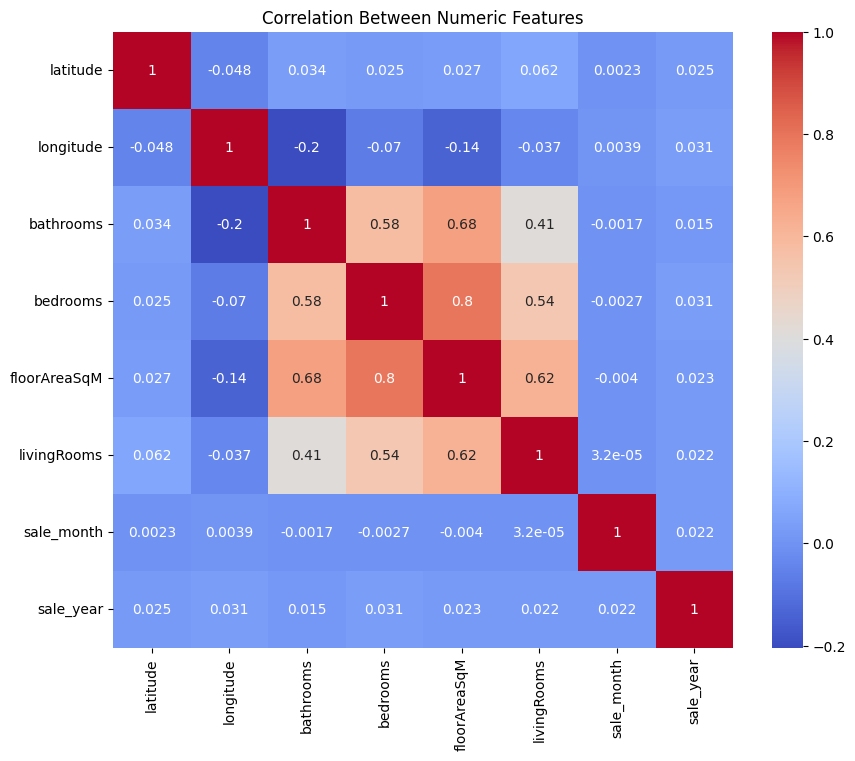

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.show()

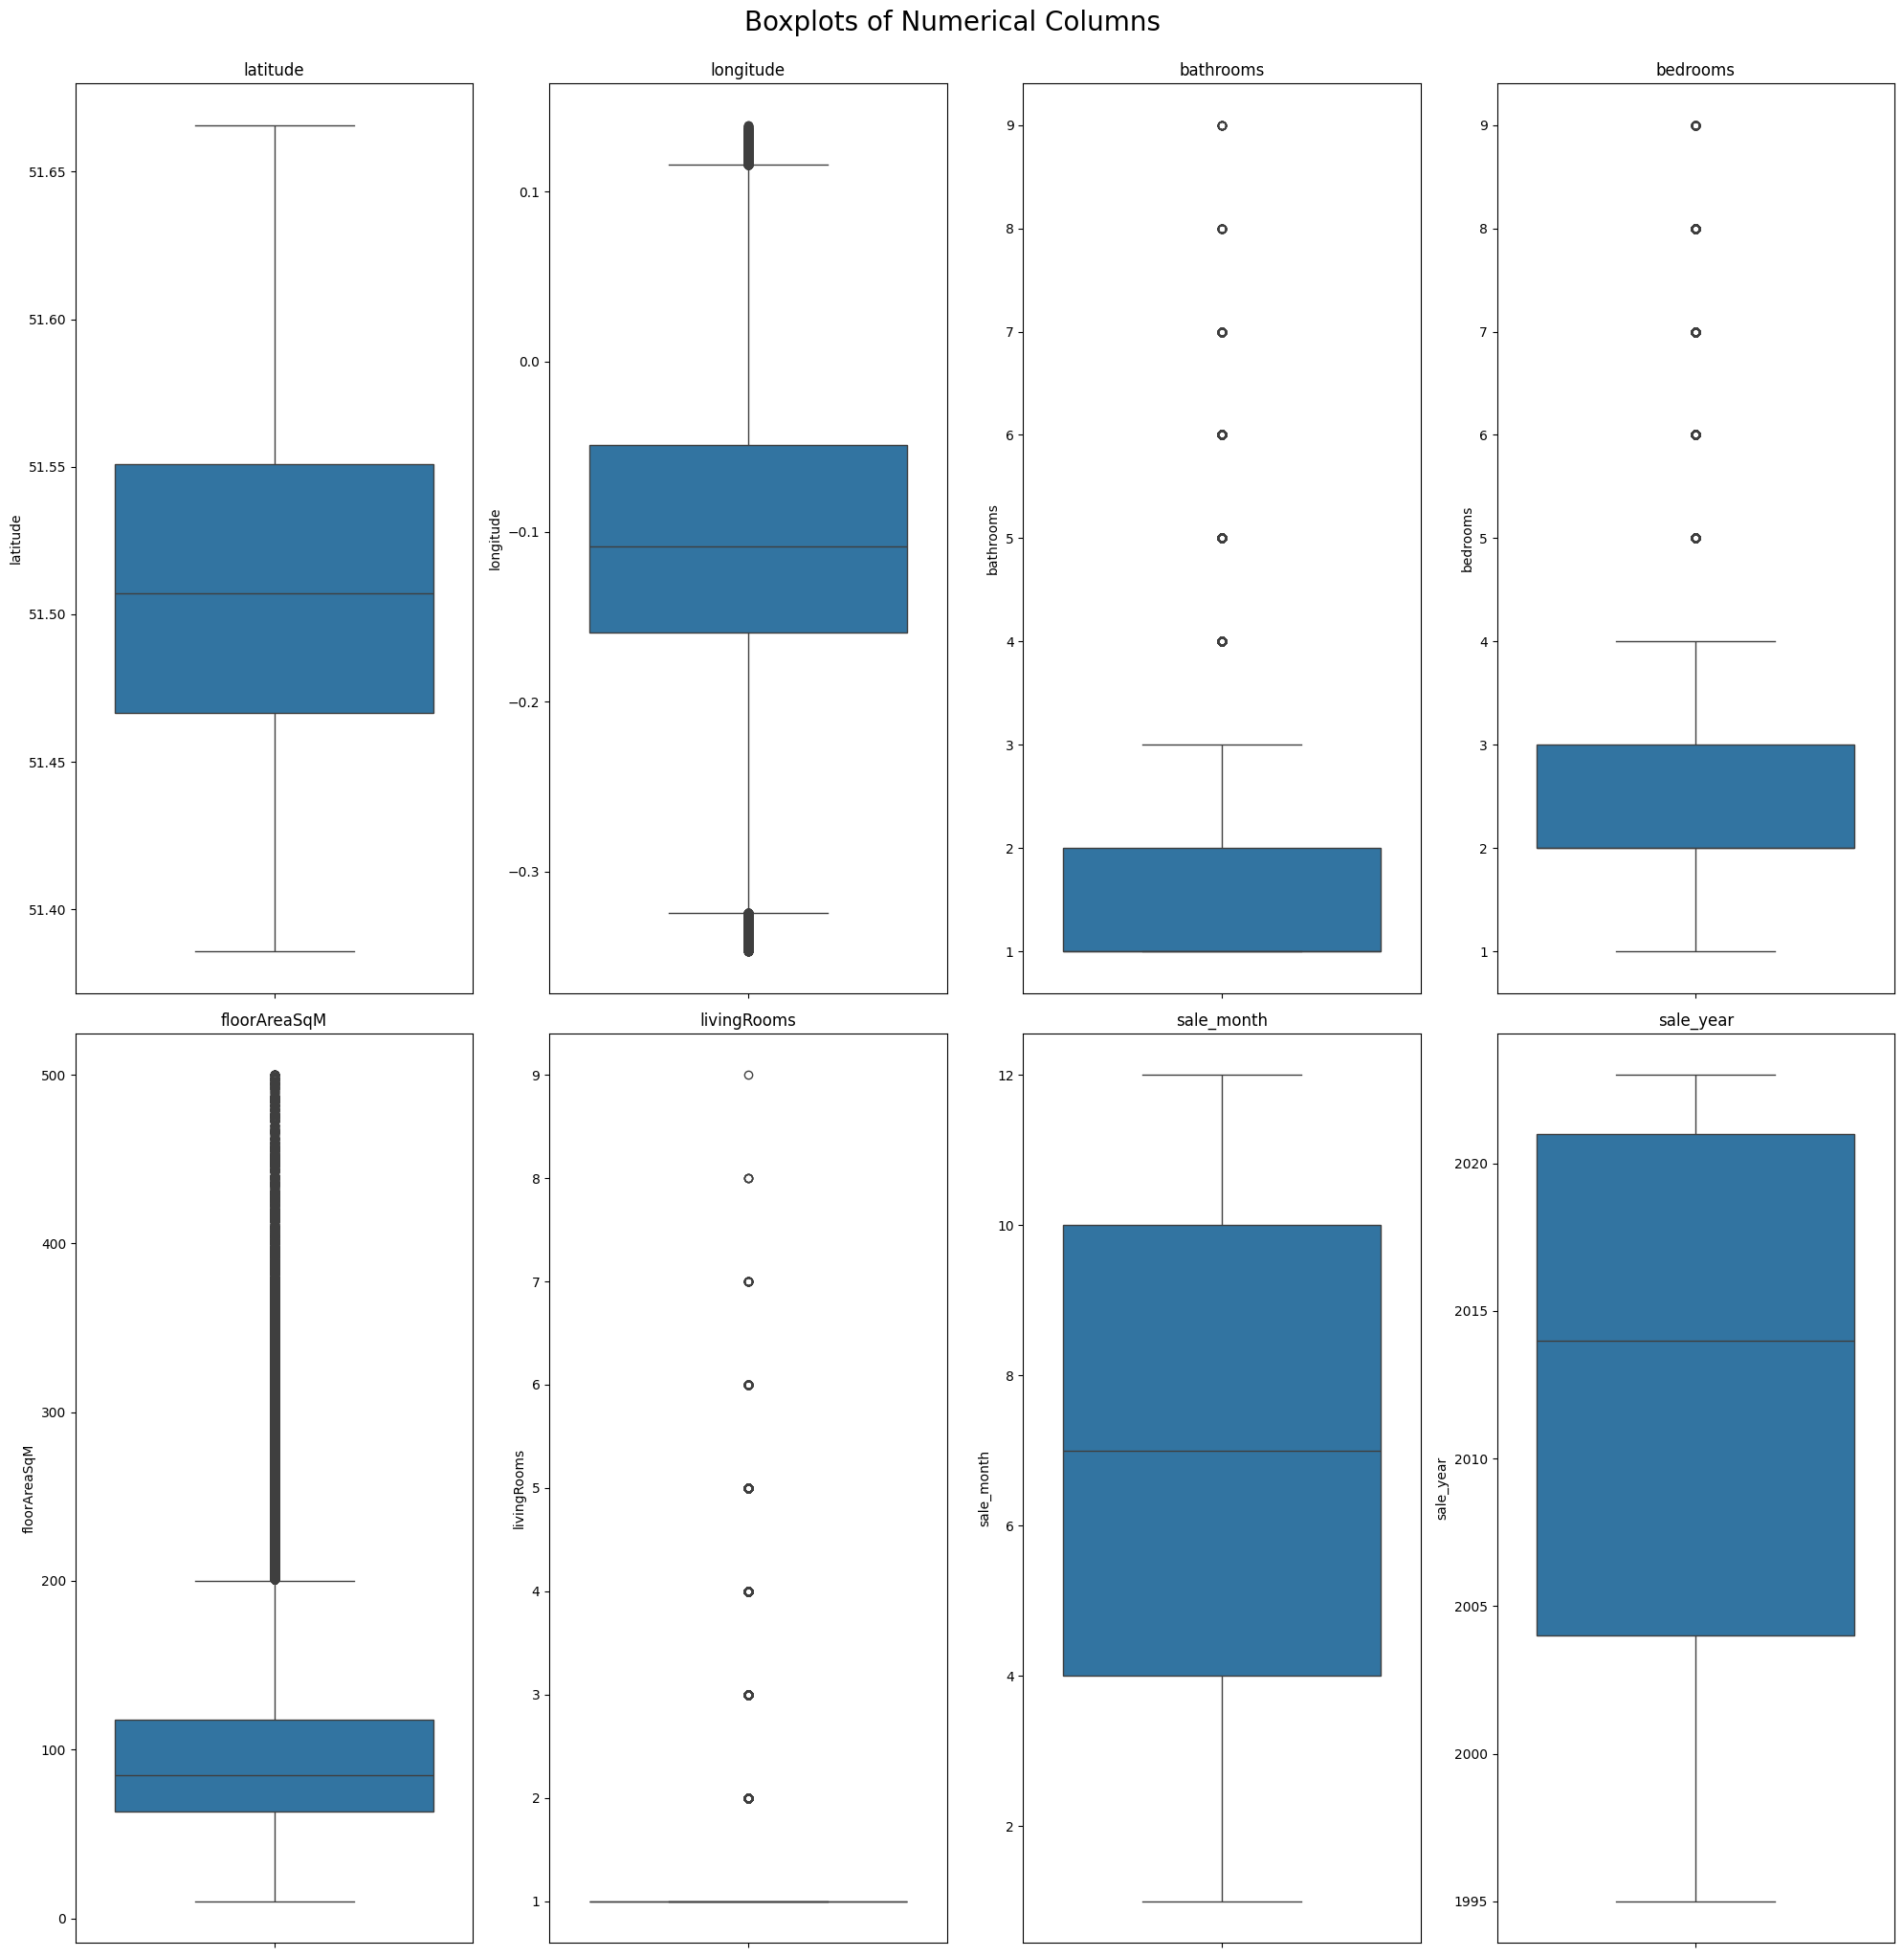

In [ ]:

n = len(numerical_cols)
cols = 4  
import math
rows = math.ceil(n / cols)

plt.figure(figsize=(20, 20))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col])
    plt.title(f'{col}')
    plt.tight_layout()

plt.suptitle('Boxplots of Numerical Columns', fontsize=20, y=1.02)
plt.show()

In [27]:
x_train.columns


Index(['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating', 'sale_month',
       'sale_year'],
      dtype='object')

here we will take '`fullAddress`', '`latitude`',
       '`longitude`', '`bathrooms`', '`bedrooms`', '`floorAreaSqM`', '`livingRooms`',
       '`tenure`', '`propertyType`', '`currentEnergyRating`', '`sale_month`',
       '`sale_year`'

In [91]:
choosed_cols = ['fullAddress','latitude','longitude','bathrooms','bedrooms','floorAreaSqM','livingRooms','tenure','propertyType','currentEnergyRating','sale_month','sale_year','outcode']


## data preprocessing

- investigating nulls to impute them 

In [29]:
print(x_train['bathrooms'].isnull().sum())

38786


In [30]:
x_train['bathrooms'].value_counts()

bathrooms
1.0    114789
2.0     46966
3.0      9444
4.0      2134
5.0       572
6.0       258
7.0        74
8.0        24
9.0        13
Name: count, dtype: int64

In [31]:
print(x_train['bedrooms'].isnull().sum())

19933


In [32]:
x_train['bedrooms'].value_counts()

bedrooms
2.0    72492
3.0    49029
1.0    37424
4.0    22160
5.0     9043
6.0     2327
7.0      471
8.0      137
9.0       44
Name: count, dtype: int64

In [33]:

print(x_train['floorAreaSqM'].isnull().sum())
print(x_train['floorAreaSqM'].describe())

11010
count    202050.000000
mean         99.656412
std          56.480051
min          10.000000
25%          63.000000
50%          85.000000
75%         118.000000
max         500.000000
Name: floorAreaSqM, dtype: float64


In [34]:


print(x_train['livingRooms'].isnull().sum())
print(x_train['livingRooms'].value_counts())

29683
livingRooms
1.0    139420
2.0     36171
3.0      6325
4.0      1102
5.0       273
6.0        60
7.0        22
8.0         3
9.0         1
Name: count, dtype: int64


- I will use a model that impute the missing values for a certain feature based on other features, and each one of the others also its null values are imputed based on the rest

- so first as we have seen a strong correclation between 'livingRooms', 'floorAreaSqM', 'bedrooms', 'bathrooms', we will use them, but first drop the rows where the four together are null.

## Kenan

In [ ]:
cols_to_check = ['livingRooms', 'floorAreaSqM', 'bedrooms', 'bathrooms']

rows_to_drop_mask = x_train[cols_to_check].isnull().all(axis=1)
x_train = x_train[~rows_to_drop_mask] 
y_train = y_train[~rows_to_drop_mask]
y_train_log = y_train_log[~rows_to_drop_mask]
print((x_train.index == y_train.index).all())

True


- here we define a new tranformer that just apply a certain function of the data, the reason of creating it like this is to allow it to be in the pipeline

## Ahmad

In [ ]:


class NamedNumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func, name_prefix="", kw_args=None):
        self.func = func
        self.name_prefix = name_prefix
        self.kw_args = kw_args if kw_args is not None else {}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X can be a DataFrame/Series or a NumPy array from a previous pipeline step
        X_np = X.values if hasattr(X, 'values') else X

        transformed_cols_data = []
        # Iterate over each column in the input X_np
        for i in range(X_np.shape[1]):
            single_column_data = X_np[:, i]
            # Apply the function to this single column
            transformed_single_column = self.func(single_column_data, **self.kw_args).reshape(-1, 1)
            transformed_cols_data.append(transformed_single_column)

        # Horizontally stack the transformed columns back together
        return np.hstack(transformed_cols_data)

    def get_feature_names_out(self, input_features=None):
        
        output_names = []
        # Generate a name for each of the input features
        for feature_name in input_features:
            output_names.append(f"{self.name_prefix}{feature_name}")
        return output_names

- here we use an iterative imputer which is the one used with the model to train on features and imputed the nulls of them,

In [ ]:


# Pipeline for numerical features (bathrooms, bedrooms, floorAreaSqM, livingRooms)
numerical_imputation_and_transform_pipeline  = Pipeline(steps=[
    ('impute_iterative', IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=40, random_state=42),
        max_iter=10, 
        random_state=42,
        initial_strategy='median' 
    )),
    ('log_transform', NamedNumericalTransformer(func=np.log1p, name_prefix="log_"))
])
# List of columns for this pipeline
numerical_cols = ['bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms']

In [10]:


print(x_train['tenure'].isnull().sum())
print(x_train['tenure'].value_counts())

4099
tenure
Leasehold    121659
Freehold      81071
Feudal         1529
Shared          524
Name: count, dtype: int64


In [11]:



print(x_train['propertyType'].isnull().sum())
print(x_train['propertyType'].value_counts())

2
propertyType
Purpose Built Flat        54845
Flat/Maisonette           45824
Mid Terrace House         36638
Converted Flat            26035
Semi-Detached House       16397
Terrace Property          12029
End Terrace House         10422
Detached House             5315
Terraced                    377
Bungalow Property           216
Semi-Detached Bungalow      191
Detached Bungalow           149
Semi-Detached Property      117
End Terrace Property        108
Detached Property            67
Mid Terrace Bungalow         55
Mid Terrace Property         38
Terraced Bungalow            30
End Terrace Bungalow         27
Name: count, dtype: int64


## MOUAZ

- null values here for `propertyType` is just two which won't affect, but for `tenure` is 4099 which kind of important to handle, we choose to impute using the `most_frequent`

In [ ]:
categorical_ohe_pipeline = Pipeline(steps=[
    ('impute_constant', SimpleImputer(strategy='most_frequent')),
    # ('one_hot_encode', OneHotEncoder(handle_unknown='ignore', # min_frequency=0.01,
    #                                  sparse_output=False)) 
])

# List of columns for this pipeline
categorical_ohe_cols = ['tenure', 'propertyType']

In [13]:


print(x_train['currentEnergyRating'].isnull().sum())
print(x_train['currentEnergyRating'].value_counts())

42074
currentEnergyRating
D    70115
C    62375
B    16482
E    16178
F     1173
G      349
A      136
Name: count, dtype: int64


## MOUAZ

- `currentEnergyRating` is an ordinal feature where order gives a strong representative meaning of the data, so we have used ordinal encoder

In [ ]:

# Pipeline for ordinal categorical feature (currentEnergyRating)
energy_rating_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

ordinal_pipeline = Pipeline(steps=[
    ('impute_unknown', SimpleImputer(strategy='constant',fill_value='Unknown')),
    ('ordinal_encode', OrdinalEncoder(categories=[energy_rating_order],
                                      handle_unknown='use_encoded_value',
                                      unknown_value=-1))
])

# List of columns for this pipeline
ordinal_cols = ['currentEnergyRating']

In [18]:

print(x_train['sale_month'].isnull().sum())
print(x_train['sale_month'].value_counts())

0
sale_month
6     20130
9     19543
8     19430
7     18862
12    18643
10    18208
11    18072
3     18032
5     15546
4     14820
2     13851
1     13745
Name: count, dtype: int64


## AHMAD

- as months are cyclic features (Feb `1` , Dec `12`) is not that far they are just one month far so we assume them like in a unit circle and use `sin` and `cos` to represent their values

In [ ]:
class NamedCyclicalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is received as a DataFrame/Series. Convert to its underlying NumPy array.
        X_np = X.values
        
        # Now X_np is a NumPy array. we Access the first column.
        X_val = X_np[:, 0].astype(float)
        sin_val = np.sin(2 * np.pi * X_val / self.period)
        cos_val = np.cos(2 * np.pi * X_val / self.period)
        return np.c_[sin_val, cos_val]

    def get_feature_names_out(self, input_features=None):
       
        original_col_name = input_features[0]
        return [f"{original_col_name}_sin", f"{original_col_name}_cos"]

In [17]:

# Pipeline for cyclical features
cyclical_pipeline = Pipeline(steps=[
    ('cyclical_transform', NamedCyclicalTransformer(period=12))
])

# List of columns for this pipeline
cyclical_cols = ['sale_month']

In [18]:



print(x_train['sale_year'].isnull().sum())
print(x_train['sale_year'].value_counts())
x_train['sale_year'].describe()

0
sale_year
2023    26130
2022    20662
2021    15582
2020     7638
2007     6858
2006     6779
2019     6769
2002     6735
2018     6685
2014     6572
1999     6536
2015     6503
2017     6393
2016     6305
2001     6140
2004     5978
2000     5840
2013     5777
1997     5596
2003     5554
1998     5534
2005     5286
1996     4627
2012     4353
2011     4138
2010     4080
1995     3557
2008     3235
2009     3040
Name: count, dtype: int64


count    208882.000000
mean       2012.232241
std           9.131150
min        1995.000000
25%        2004.000000
50%        2014.000000
75%        2021.000000
max        2023.000000
Name: sale_year, dtype: float64

## AHMAD

- we have a conecpt `year since a reference point` which is two set a year as reference and subtract it from the years in the data so that we get the elapsed years by their difference not as large numbers

In [19]:
# Function for linear temporal transformation (years since a reference)
def years_since_func(X_val, reference_year):
    return (X_val - reference_year)

sale_year_pipeline = Pipeline(steps=[
    ('years_since_transform', NamedNumericalTransformer(
        func=years_since_func,
        name_prefix="years_since_",
        kw_args={'reference_year': 1990}))
])

# List of columns for this pipeline
temporal_linear_cols = ['sale_year']

## KENANA AND MOUAZ

In [23]:
unprocessed_chosen_features = ['fullAddress', 'latitude', 'longitude','outcode']

In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ('select_features', 'passthrough', unprocessed_chosen_features),
        ('skewed_numerical_preproc', numerical_imputation_and_transform_pipeline, numerical_cols),
        ('ohe_categorical_preproc', categorical_ohe_pipeline, categorical_ohe_cols),
        ('ordinal_categorical_preproc', ordinal_pipeline, ordinal_cols),
        ('cyclical_preproc', cyclical_pipeline, cyclical_cols),
        ('sale_year_preproc', sale_year_pipeline, temporal_linear_cols)
    ],
    remainder='drop'
,verbose=True)

preprocessor.set_output(transform='pandas')



,transformers,"[('select_features', ...), ('skewed_numerical_preproc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,True
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,estimator,RandomForestR...ndom_state=42)
,missing_values,nan
,sample_posterior,False


In [25]:
x_train.columns

Index(['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating', 'sale_month',
       'sale_year'],
      dtype='object')

In [ ]:

processed_data = preprocessor.fit_transform(x_train)
print(processed_data.shape) 

[ColumnTransformer]  (1 of 6) Processing select_features, total=   0.0s


c:\Users\Ahmad Abboud\Desktop\Machine learning\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 6) Processing skewed_numerical_preproc, total= 3.1min
[ColumnTransformer]  (3 of 6) Processing ohe_categorical_preproc, total=   0.1s
[ColumnTransformer]  (4 of 6) Processing ordinal_categorical_preproc, total=   0.1s
[ColumnTransformer]  (5 of 6) Processing cyclical_preproc, total=   0.0s
[ColumnTransformer]  (6 of 6) Processing sale_year_preproc, total=   0.0s
(208882, 14)


In [39]:
processed_data.columns

Index(['select_features__fullAddress', 'select_features__latitude',
       'select_features__longitude', 'select_features__outcode',
       'skewed_numerical_preproc__log_bathrooms',
       'skewed_numerical_preproc__log_bedrooms',
       'skewed_numerical_preproc__log_floorAreaSqM',
       'skewed_numerical_preproc__log_livingRooms',
       'ohe_categorical_preproc__tenure',
       'ohe_categorical_preproc__propertyType',
       'ordinal_categorical_preproc__currentEnergyRating',
       'cyclical_preproc__sale_month_sin', 'cyclical_preproc__sale_month_cos',
       'sale_year_preproc__years_since_sale_year'],
      dtype='object')

In [40]:
processed_data.head()

,select_features__fullAddress,select_features__latitude,select_features__longitude,select_features__outcode,skewed_numerical_preproc__log_bathrooms,skewed_numerical_preproc__log_bedrooms,skewed_numerical_preproc__log_floorAreaSqM,skewed_numerical_preproc__log_livingRooms,ohe_categorical_preproc__tenure,ohe_categorical_preproc__propertyType,ordinal_categorical_preproc__currentEnergyRating,cyclical_preproc__sale_month_sin,cyclical_preproc__sale_month_cos,sale_year_preproc__years_since_sale_year
62556,"Flat 6, 7 De Crespigny Park, London, SE5 8AB",51.470484,-0.090867,SE5,0.693147,0.693147,3.970292,0.696341,Leasehold,Flat/Maisonette,3.0,-8.660254e-01,5.000000e-01,13
19893,"Flat 3, Felix Studios, 29 Felix Avenue, London...",51.580456,-0.122099,N8,1.098612,1.098612,4.382027,0.693147,Leasehold,Converted Flat,1.0,5.000000e-01,-8.660254e-01,8
197684,"Flat 35, Shelley House, London, SW1V 3JD",51.485468,-0.139674,SW1V,0.693147,0.693147,3.761200,0.693147,Leasehold,Purpose Built Flat,2.0,1.224647e-16,-1.000000e+00,31
149641,"7 William Brown Court, Norwood Road, London, S...",51.437576,-0.105073,SE27,0.693147,1.386294,4.634729,0.693147,Leasehold,Purpose Built Flat,-1.0,-1.000000e+00,-1.836970e-16,26
133936,"21C Deronda Road, London, SE24 9BQ",51.444199,-0.106454,SE24,0.693147,1.098612,4.204693,0.693147,Leasehold,Purpose Built Flat,4.0,-8.660254e-01,5.000000e-01,24


In [41]:
# after fitting the data to see the names:
output_feature_names = preprocessor.get_feature_names_out()
print("New Column Names from the first preprocessor:")
print(len(output_feature_names))

New Column Names from the first preprocessor:
14


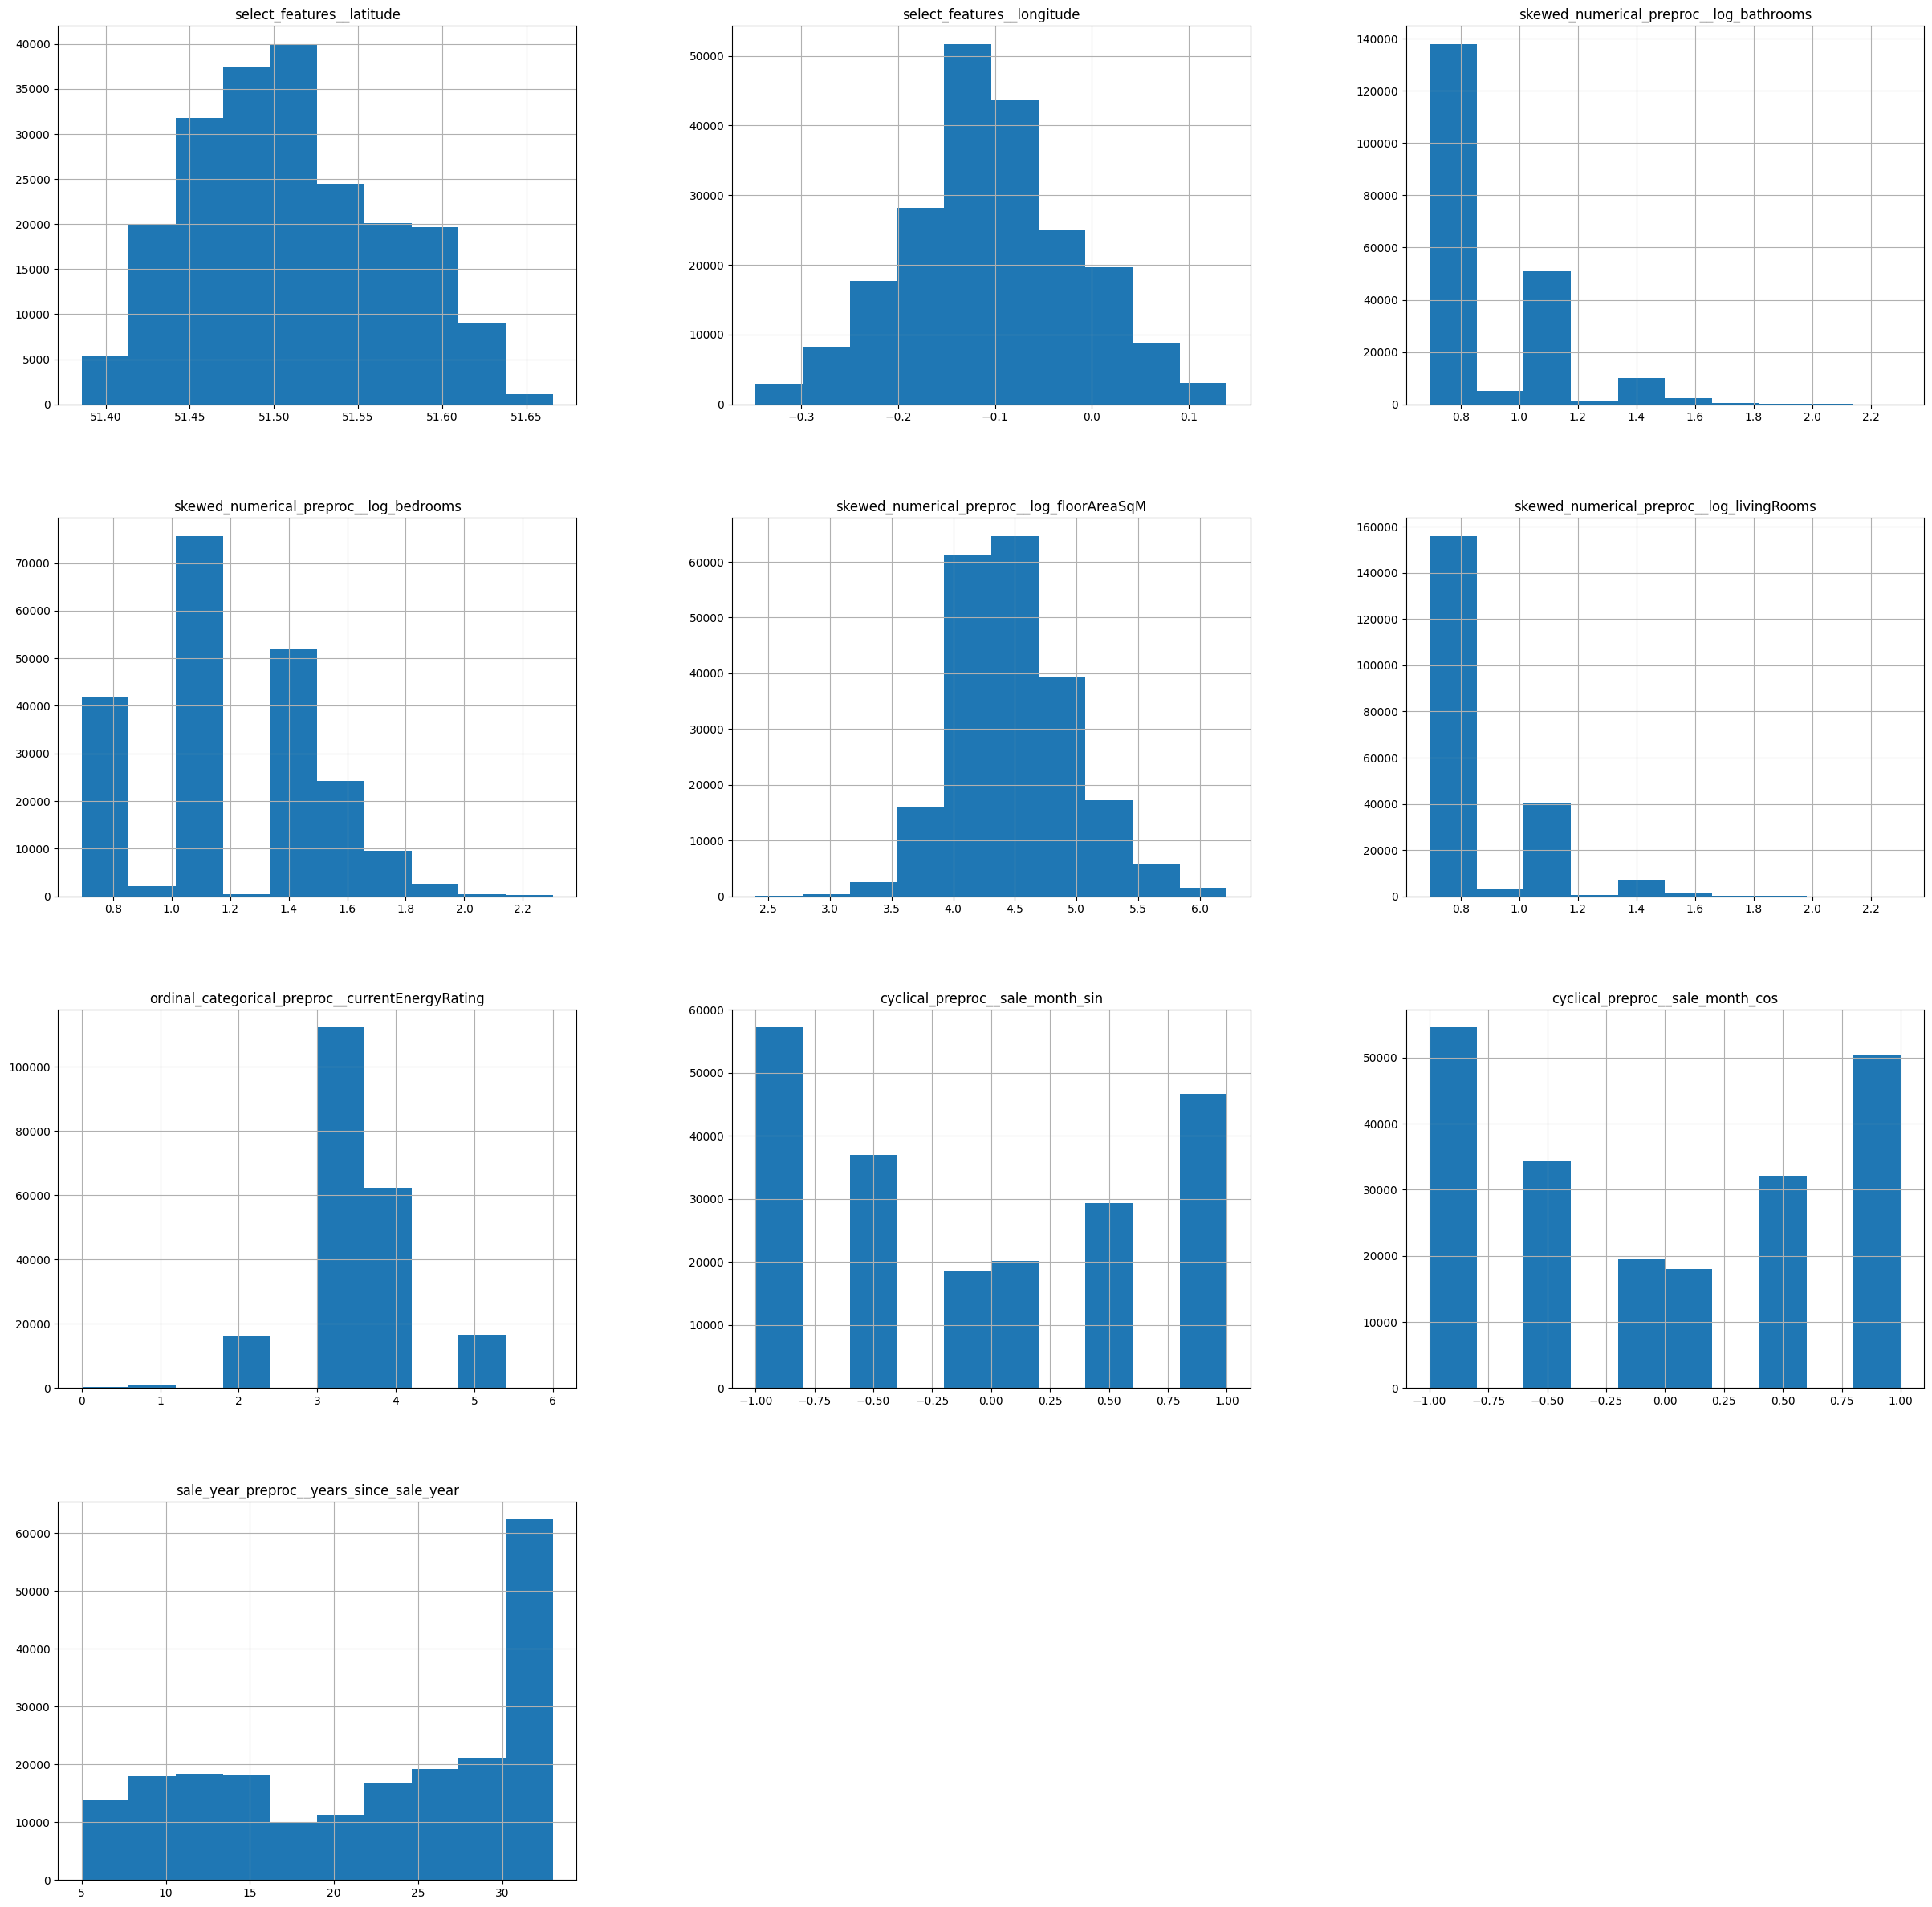

In [90]:
processed_data.hist(figsize=(30, 30))
plt.show()

- we can notice that some skewness has been solved after this step in the data of floorAreaSM and months (sin, cos), also kind of for bedrooms

## Feature Engineering

## MOUAZ

- to extract the city from the full address

In [ ]:

class CityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        address_series = X.iloc[:, 0] 
        
        split_components = address_series.str.rsplit(', ', expand=True, n=2)
        
        city_column_data = split_components.iloc[:, 1]
        
        city_column_data = city_column_data.fillna('UnknownCity') 
        
        return city_column_data.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        
        original_col_name = input_features[0].split('__')[-1] 
        return [f"{original_col_name}_city"]

- to calculate the distance from the center of london as their might be a relation between pricing and how near are they from the center

## AHMAD

In [ ]:
from geopy.distance import geodesic 

center_coords = (51.5074, -0.1278)


class DistanceFromCenterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, center_coords):
        self.center_coords = center_coords

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        latitude = X.iloc[:, 0]
        longitude = X.iloc[:, 1]

        # Combine them into a Series of tuples (property_coords)
        property_coords_series = list(zip(latitude, longitude))

        # Apply the geodesic distance calculation to each coordinate pair
        distances_km = np.array([
            geodesic(self.center_coords, prop_coords).kilometers
            for prop_coords in property_coords_series
        ])

        
        return distances_km.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        
        return ['distance_from_center_km']

## KENANA

- here we calculate the totalroom = `bathrooms` + `livingrooms` + `bedrooms`

In [ ]:

class TotalRoomsCalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X will contain the log-transformed values from the preprocessor:
        # 'skewed_numerical_preproc__log_bedrooms' (X.iloc[:, 0])
        # 'skewed_numerical_preproc__log_livingRooms' (X.iloc[:, 1])
        # 'skewed_numerical_preproc__log_bathrooms' (X.iloc[:, 2])
        

        
        log_bedrooms_input = X.iloc[:, 0]
        log_livingrooms_input = X.iloc[:, 1]
        log_bathrooms_input = X.iloc[:, 2]

        # Reverse the log transformation to get approximate original values for summing
        # Assuming np.log1p was used for the original transformation, so np.expm1 is the inverse.
        bedrooms_original_approx = np.expm1(log_bedrooms_input)
        livingrooms_original_approx = np.expm1(log_livingrooms_input)
        bathrooms_original_approx = np.expm1(log_bathrooms_input)

        
        total_rooms_sum = bedrooms_original_approx + livingrooms_original_approx + bathrooms_original_approx

        
        log_total_rooms = np.log1p(total_rooms_sum)

        
        
        output_data = np.hstack((
            log_bedrooms_input.values.reshape(-1, 1),
            log_livingrooms_input.values.reshape(-1, 1),
            log_bathrooms_input.values.reshape(-1, 1),
            log_total_rooms.values.reshape(-1, 1)
        ))

        return output_data

    def get_feature_names_out(self, input_features=None):
       
        output_names = list(input_features) 
        output_names.append('log_total_rooms')
        return output_names

In [46]:
from sklearn.preprocessing import PolynomialFeatures

## AHMAD

- also we use knn to see the clusters of lat and lng in the data to cluster the nearest houses together and got better view on the data

In [ ]:
class KMeansClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=8, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None # Will store the fitted KMeans model

    def fit(self, X, y=None):
        # X will contain latitude and longitude columns
        # Fit KMeans on the provided latitude and longitude data
        self.kmeans = KMeans(n_clusters=self.n_clusters,
                             random_state=self.random_state,
                             n_init='auto') 
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        
        cluster_labels = self.kmeans.predict(X)

        # Return the cluster labels as a 2D NumPy array
        return cluster_labels.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        # Outputs a single new feature name for the cluster ID
        return [f'geo_cluster_k{self.n_clusters}_id']

## AHMAD & KENANA & MOUAZ

In [ ]:
feature_engineering_transformer = ColumnTransformer(
    transformers=[
        ('extract_city',
         CityExtractor(), 
         ['select_features__fullAddress']), 
        
        ('distance_from_center',
         DistanceFromCenterTransformer(center_coords=center_coords),
         ['select_features__latitude', 'select_features__longitude']),
        
        ('calculate_total_rooms',
         TotalRoomsCalculator(),
         [   'skewed_numerical_preproc__log_bedrooms',
             'skewed_numerical_preproc__log_livingRooms',
             'skewed_numerical_preproc__log_bathrooms'
         ]),
        ('geo_cluster_id', KMeansClusterTransformer(n_clusters=10, random_state=42), 
         ['select_features__latitude', 'select_features__longitude'])
      
    ],
    remainder='passthrough'
)

feature_engineering_transformer.set_output(transform='pandas')


,transformers,"[('extract_city', ...), ('distance_from_center', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,center_coords,"(51.5074, ...)"
,n_clusters,10
,random_state,42


In [49]:
feature_engineered_data = feature_engineering_transformer.fit_transform(processed_data)
print(feature_engineered_data.shape)

(208882, 15)


In [51]:
feature_engineered_data.dtypes

extract_city__fullAddress_city                                       object
distance_from_center__distance_from_center_km                       float64
calculate_total_rooms__skewed_numerical_preproc__log_bedrooms       float64
calculate_total_rooms__skewed_numerical_preproc__log_livingRooms    float64
calculate_total_rooms__skewed_numerical_preproc__log_bathrooms      float64
calculate_total_rooms__log_total_rooms                              float64
geo_cluster_id__geo_cluster_k10_id                                    int32
remainder__select_features__outcode                                  object
remainder__skewed_numerical_preproc__log_floorAreaSqM               float64
remainder__ohe_categorical_preproc__tenure                           object
remainder__ohe_categorical_preproc__propertyType                     object
remainder__ordinal_categorical_preproc__currentEnergyRating         float64
remainder__cyclical_preproc__sale_month_sin                         float64
remainder__c

In [53]:
feature_engineered_data.head()

,extract_city__fullAddress_city,distance_from_center__distance_from_center_km,calculate_total_rooms__skewed_numerical_preproc__log_bedrooms,calculate_total_rooms__skewed_numerical_preproc__log_livingRooms,calculate_total_rooms__skewed_numerical_preproc__log_bathrooms,calculate_total_rooms__log_total_rooms,geo_cluster_id__geo_cluster_k10_id,remainder__select_features__outcode,remainder__skewed_numerical_preproc__log_floorAreaSqM,remainder__ohe_categorical_preproc__tenure,remainder__ohe_categorical_preproc__propertyType,remainder__ordinal_categorical_preproc__currentEnergyRating,remainder__cyclical_preproc__sale_month_sin,remainder__cyclical_preproc__sale_month_cos,remainder__sale_year_preproc__years_since_sale_year
62556,London,4.842506,0.693147,0.696341,0.693147,1.387893,7,SE5,3.970292,Leasehold,Flat/Maisonette,3.0,-8.660254e-01,5.000000e-01,13
19893,London,8.137729,1.098612,0.693147,1.098612,1.791759,3,N8,4.382027,Leasehold,Converted Flat,1.0,5.000000e-01,-8.660254e-01,8
197684,London,2.575696,0.693147,0.693147,0.693147,1.386294,0,SW1V,3.761200,Leasehold,Purpose Built Flat,2.0,1.224647e-16,-1.000000e+00,31
149641,London,7.927320,1.386294,0.693147,0.693147,1.791759,7,SE27,4.634729,Leasehold,Purpose Built Flat,-1.0,-1.000000e+00,-1.836970e-16,26
133936,London,7.186294,1.098612,0.693147,0.693147,1.609438,7,SE24,4.204693,Leasehold,Purpose Built Flat,4.0,-8.660254e-01,5.000000e-01,24


- there was a step to hot endcode the city after extracting it, but now we are working by passing the categorical features directly to the model, and it will handle the way of encoding them

## MOUAZ

In [ ]:
city_encoding_transformer = ColumnTransformer(
    transformers=[
        ('encode_city_final', 
         OneHotEncoder(handle_unknown='ignore', 
                    #    min_frequency=0.01, 
                       sparse_output=False), 
         ['extract_city__fullAddress_city']) 
    ],
    remainder='passthrough' 
)
city_encoding_transformer.set_output(transform='pandas')

,transformers,"[('encode_city_final', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


## AHMAD

- because we are passing the categorical features to the model, it is a good practice to **transform** the dype of those features and make it `category`

In [ ]:
class ConvertToCategoryDtype(BaseEstimator, TransformerMixin):
            def __init__(self, cols_to_convert):
                self.cols_to_convert = cols_to_convert
            def fit(self, X, y=None):
                return self
            def transform(self, X):
                X_copy = X.copy()
                for col in self.cols_to_convert:
                    if col in X_copy.columns:
                       
                        
                        
                        if X_copy[col].dtype == 'object': #  for tenure, propertyType
                            X_copy[col] = X_copy[col].astype('category')
                        elif 'id' in col: # for cluster IDs
                             X_copy[col] = X_copy[col].astype(int).astype('category')
                return X_copy
            def get_feature_names_out(self, input_features=None):
                return input_features # Names remain the same

In [56]:
from sklearn.compose import make_column_selector as selector

## KENANA

- we put the scaling step in a *ColumnTransformer* so that we have **select** the column that are not category or object to ensure its ability to scale

In [ ]:
numerical_scaling_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), selector(dtype_exclude=['object', 'category'])) # Selects all numerical columns
    ],
    remainder='passthrough' 
)
numerical_scaling_transformer.set_output(transform='pandas')


,transformers,"[('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [58]:
full_preprocessing_pipeline = Pipeline(steps=[
    ('initial_data_preparation', preprocessor),
    ('feature_engineering_step', feature_engineering_transformer),
    # ('city_encoding_step', city_encoding_transformer),
    ('convert_to_category_dtype', ConvertToCategoryDtype(
                cols_to_convert=[
                    'extract_city__fullAddress_city',
                    'remainder__select_features__outcode',
                    'geo_cluster_id__geo_cluster_k10_id',
                    'remainder__ohe_categorical_preproc__tenure',
                    'remainder__ohe_categorical_preproc__propertyType'
                ]
            ),),
    ('numerical_scaling_step', numerical_scaling_transformer)
])
full_preprocessing_pipeline.set_output(transform='pandas')


,steps,"[('initial_data_preparation', ...), ('feature_engineering_step', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('select_features', ...), ('skewed_numerical_preproc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,True
,verbose_feature_names_out,True


In [ ]:
data_f = full_preprocessing_pipeline.fit_transform(feature_engineered_data)
print(data_f.shape)

In [125]:
data_f.dtypes

scaler__distance_from_center__distance_from_center_km                        float64
scaler__calculate_total_rooms__skewed_numerical_preproc__log_bedrooms        float64
scaler__calculate_total_rooms__skewed_numerical_preproc__log_livingRooms     float64
scaler__calculate_total_rooms__skewed_numerical_preproc__log_bathrooms       float64
scaler__calculate_total_rooms__log_total_rooms                               float64
scaler__remainder__skewed_numerical_preproc__log_floorAreaSqM                float64
scaler__remainder__ordinal_categorical_preproc__currentEnergyRating          float64
scaler__remainder__cyclical_preproc__sale_month_sin                          float64
scaler__remainder__cyclical_preproc__sale_month_cos                          float64
scaler__remainder__sale_year_preproc__years_since_sale_year                  float64
remainder__extract_city__fullAddress_city                                   category
remainder__geo_cluster_id__geo_cluster_k10_id                    

- testing on diferent models:
    - LinearRegression
    - XGBRegressor
    - CatBoostRegressor
    - LGBMRegressor
    

In [60]:
# 1. Linear Regression Pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', full_preprocessing_pipeline),
    ('regressor', LinearRegression())
])

In [61]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', full_preprocessing_pipeline),
    ('regressor', XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
])

## MOUAZ & KENANA

In [65]:
pipeline_cat = Pipeline(steps=[
    ('preprocessor', full_preprocessing_pipeline),
    ('regressor', CatBoostRegressor(random_state=42, iterations=4096*4, learning_rate=0.08, verbose=100,
                                    l2_leaf_reg=0.4,
                                    depth=8,
                                    bagging_temperature=0.5,
                                    border_count=128,
                                    cat_features=[
                                        'remainder__extract_city__fullAddress_city',  
                                        'remainder__remainder__select_features__outcode',                                 
                                        'remainder__geo_cluster_id__geo_cluster_k10_id'  ,       
                                        'remainder__remainder__ohe_categorical_preproc__tenure' ,
                                        'remainder__remainder__ohe_categorical_preproc__propertyType'                                                             
                                    ]))
])

## AHMAD

In [89]:
pipeline_lgm = Pipeline(steps=[
    ('preprocessor', full_preprocessing_pipeline), 
    ('regressor', LGBMRegressor(random_state=42,n_estimators=10000,learning_rate=0.05,num_leaves=31,max_depth=8,subsample=0.8,reg_alpha=0.2,reg_lambda=0.2,verbose=100))
    ])


In [90]:
pipeline_lgm.fit(x_train, y_train_log)
y_pred = pipeline_lgm.predict(x_val)
y_original_pred = np.expm1(y_pred)
mae = mean_absolute_error(y_val, y_original_pred)

print(f"LGBM MAE: {mae:.4f}")

[ColumnTransformer]  (1 of 6) Processing select_features, total=   0.0s
[ColumnTransformer]  (2 of 6) Processing skewed_numerical_preproc, total= 3.5min
[ColumnTransformer]  (3 of 6) Processing ohe_categorical_preproc, total=   0.1s
[ColumnTransformer]  (4 of 6) Processing ordinal_categorical_preproc, total=   0.1s
[ColumnTransformer]  (5 of 6) Processing cyclical_preproc, total=   0.0s
[ColumnTransformer]  (6 of 6) Processing sale_year_preproc, total=   0.0s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.850782
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.124125
[LightGBM] [Debug] init for col-wise cost 0.007663 seconds, init for row-wise cost 0.014772 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGB

In [66]:
# --- Train and Evaluate ---

models = {
    # "Linear Regression": pipeline_lr,
    # "XGBoost": pipeline_xgb,
    "CatBoost": pipeline_cat
}

results = {}

for name, pipeline in models.items():
    print(f"\n--- Training {name} ---")
    try:
        pipeline.fit(x_train, y_train_log)
        y_pred = pipeline.predict(x_val)
        y_original_pred = np.expm1(y_pred)
        mae = mean_absolute_error(y_val, y_original_pred)
        results[name] = mae
        print(f"{name} MAE: {mae:.4f}")
    except Exception as e:
        results[name] = f"Error: {e}"
        print(f"Error training {name}: {e}")



--- Training CatBoost ---
[ColumnTransformer]  (1 of 6) Processing select_features, total=   0.0s


c:\Users\Ahmad Abboud\Desktop\Machine learning\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 6) Processing skewed_numerical_preproc, total= 3.3min
[ColumnTransformer]  (3 of 6) Processing ohe_categorical_preproc, total=   0.1s
[ColumnTransformer]  (4 of 6) Processing ordinal_categorical_preproc, total=   0.1s
[ColumnTransformer]  (5 of 6) Processing cyclical_preproc, total=   0.0s
[ColumnTransformer]  (6 of 6) Processing sale_year_preproc, total=   0.0s
0:	learn: 0.8674734	total: 511ms	remaining: 2h 19m 36s
100:	learn: 0.3492177	total: 31.5s	remaining: 1h 24m 39s
200:	learn: 0.3354755	total: 1m 3s	remaining: 1h 24m 42s
300:	learn: 0.3276459	total: 1m 35s	remaining: 1h 24m 59s
400:	learn: 0.3215259	total: 2m 7s	remaining: 1h 24m 24s
500:	learn: 0.3167551	total: 2m 39s	remaining: 1h 24m 18s
600:	learn: 0.3128909	total: 3m 10s	remaining: 1h 23m 24s
700:	learn: 0.3092675	total: 3m 42s	remaining: 1h 22m 57s
800:	learn: 0.3061493	total: 4m 12s	remaining: 1h 21m 54s
900:	learn: 0.3031897	total: 4m 42s	remaining: 1h 20m 50s
1000:	learn: 0.3003129	total: 5m 1

c:\Users\Ahmad Abboud\Desktop\Machine learning\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Ahmad Abboud\Desktop\Machine learning\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Ahmad Abboud\Desktop\Machine learning\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


CatBoost MAE: 147248.2847


### Conclusion
we have trained the data on two models `CatBoostRegressor` and `LGBMRegressor`:



| Feature/Metric               | LightGBM (`pipeline_lgm`)                                                                                                                                                                                                                              | CatBoost (`pipeline_cat`)                                                                                                                                                                                                                                                                                                                                                                |
| :--------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Regressor Type** | Light Gradient Boosting Machine (LGBM)                                                                                                                                                                                                                 | Categorical Boosting (CatBoost)                                                                                                                                                                                                                                                                                                                                                          |
| **Preprocessing Pipeline** | `full_preprocessing_pipeline` (same for both models)                                                                                                                                                                                                 | `full_preprocessing_pipeline` (same for both models)                                                                                                                                                                                                                                                                                                                                   |
| **Key Parameters** | `random_state=42`, `n_estimators=10000`, `learning_rate=0.05`, `num_leaves=31`, `max_depth=8`, `subsample=0.8`, `reg_alpha=0.2`, `reg_lambda=0.2`, `verbose=100`                                                                                         | `random_state=42`, `iterations=4096*4` (16384), `learning_rate=0.08`, `verbose=100`, `l2_leaf_reg=0.4`, `depth=8`, `bagging_temperature=0.5`, `border_count=128`                                                                                                                                                                                                                         |
| **Categorical Handling** | Automatic detection based on `pandas.CategoricalDtype` (managed by `ConvertToCategoryDtype` in scaling transformer within `full_preprocessing_pipeline`).                                                                | Explicitly defined `cat_features` list: <br> `['remainder__extract_city__fullAddress_city', ` <br> `'remainder__remainder__select_features__outcode',` <br> `'remainder__geo_cluster_id__geo_cluster_k10_id',` <br> `'remainder__remainder__ohe_categorical_preproc__tenure',` <br> `'remainder__remainder__ohe_categorical_preproc__propertyType']`                                       |
| **MAE (Evaluation Set)** | `146886.0171`                                                                                                                                                                                                                                          | `147248.2847`                                                                                                                                                                                                                                                                                                                                                                            |
| **MAE (Test Set)** | `178054.523072`                                                                                                                                                                                                                                        | `180517.295320`                                                                                                                                                                                                                                                                                                                                                                          |
| **Performance Notes** | Achieved slightly lower MAE on both evaluation and test sets, suggesting marginally better generalization for this specific problem and hyperparameter set.                                                                                             | Achieved slightly higher MAE on both evaluation and test sets, indicating marginally less accurate predictions in this specific setup compared to LightGBM. The overall performance is very close.                                                                                                                                                                                           |

In [72]:
print("\n--- Model Evaluation Results (MAE) ---")
for name, mae_score in results.items():
    print(f"{name}: {mae_score:.4f}" if isinstance(mae_score, float) else f"{name}: {mae_score}")



--- Model Evaluation Results (MAE) ---
CatBoost: 147248.2847


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [74]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


In [ ]:
param_grid_lr = {
    'regressor__fit_intercept': [True, False],
    # 'regressor__copy_X': [True, False] 
}

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'regressor__n_estimators': [ 3000],
    'regressor__learning_rate': [ 0.05],
    'regressor__max_depth': [7,10], 
    'regressor__subsample': [0.8], 
    # 'regressor__gamma': [0, 0.1, 0.2], 
    'regressor__reg_lambda': [0.1], # L2 regularization term on weights
}


# # Hyperparameter grid for CatBoost
# param_grid_cat = {
#     'regressor__iterations': [300,500], 
#     'regressor__learning_rate': [0.05,0.01], 
#     'regressor__depth': [6, 8], 
#     'regressor__l2_leaf_reg': [3, 5], 
#     'regressor__border_count': [128], 
#     # 'regressor__loss_function': ['RMSE', 'MAE'] 
# }


param_grid_lgbm = {
    'regressor__n_estimators': [5000,6000,7000],
    'regressor__learning_rate': [0.05,0.2],
    'regressor__num_leaves': [64], 
    'regressor__max_depth': [-1],
    'regressor__subsample': [0.8],
    # 'regressor__colsample_bytree': [0.8],
    'regressor__reg_alpha': [0.1,0.3],
    'regressor__reg_lambda': [0.2],
}

In [ ]:

# --- Model Pipelines with Grid Search ---

# Define a dictionary of models and their respective parameter grids
models_and_grids = {
    # "Linear Regression": {
    #     "pipeline": Pipeline(steps=[('preprocessor', full_preprocessing_pipeline), ('regressor', LinearRegression())]),
    #     "param_grid": param_grid_lr
    # },
    # "XGBoost": {
    #     "pipeline": Pipeline(steps=[('preprocessor', full_preprocessing_pipeline), ('regressor', XGBRegressor(random_state=42))]),
    #     "param_grid": param_grid_xgb
    # },
    # "CatBoost": {
    #     "pipeline": Pipeline(steps=[('preprocessor', full_preprocessing_pipeline), ('regressor', CatBoostRegressor(random_state=42, verbose=1))]),
    #     "param_grid": param_grid_cat
    # },
    "LightGBM": { 
        "pipeline": Pipeline(steps=[('preprocessor', full_preprocessing_pipeline), ('regressor', LGBMRegressor(random_state=42))]),
        "param_grid": param_grid_lgbm
    }
}


In [ ]:

best_results = {}

for name, config in models_and_grids.items():
    print(f"\n--- Running GridSearchCV for {name} ---")

    
    grid_search = GridSearchCV(
        estimator=config["pipeline"],
        param_grid=config["param_grid"],
        cv=3, 
        scoring=mae_scorer, # Use the MAE scorer (negated for maximization)
        verbose=1, 
        n_jobs=-1 # Use all available CPU cores
    )

    
        
        
    grid_search.fit(x_train, y_train_log)

    # Get the best estimator and its performance
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_mae = -grid_search.best_score_ # Convert back to positive MAE

    # Predict on the test set (predictions will be on the transformed scale)
    y_pred_transformed_val = best_pipeline.predict(x_val)
    # Inverse transform predictions back to the original price scale
    y_pred_original_scale_val = np.expm1(y_pred_transformed_val)

    # Calculate MAE on the original price scale (using y_test_original)
    test_mae_original_scale = mean_absolute_error(y_val, y_pred_original_scale_val)

    best_results[name] = {
        "Best CV MAE": best_mae,
        "Test MAE": test_mae_original_scale,
        "Best Parameters": best_params,
        "Best Estimator": best_pipeline
    }
    print(f"Finished GridSearchCV for {name}")
    print(f"  Best CV MAE: {best_mae:.4f}")
    print(f"  Test MAE with Best Model: {test_mae_original_scale:.4f}")
    print(f"  Best Parameters: {best_params}")

    

print("\n--- Optimized Model Evaluation Results (MAE) ---")
for name, results in best_results.items():
    if isinstance(results, dict):
        print(f"\n{name}:")
        print(f"  Best CV MAE: {results['Best CV MAE']:.4f}")
        print(f"  Test MAE: {results['Test MAE']:.4f}")
        print(f"  Best Parameters: {results['Best Parameters']}")
    else:
        print(f"\n{name}: {results}")

In [ ]:

best_xgboost_pipeline = pipeline_lgm

print("Best LightGBM Pipeline retrieved successfully.")


Best LightGBM Pipeline retrieved successfully.


In [ ]:


kaggle_test_df = pd.read_csv('test.csv')
print(f"Kaggle test data loaded. Shape: {kaggle_test_df.shape}")
print("Columns:", kaggle_test_df.columns.tolist())

#  keeping the 'Id' column for the submission file
test_ids = kaggle_test_df['ID']

X_kaggle_test = kaggle_test_df.drop('ID', axis=1, errors='ignore')


Kaggle test data loaded. Shape: (16547, 16)
Columns: ['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'tenure', 'propertyType', 'currentEnergyRating', 'sale_month', 'sale_year']


In [ ]:
print("Making predictions on Kaggle test data...")
predictions_transformed = best_xgboost_pipeline.predict(X_kaggle_test)

predictions_original_scale = np.expm1(predictions_transformed)

print("Predictions generated and inverse-transformed.")
# checking for any negative predictions if data could lead to that
# For prices, negative predictions are usually impossible, so we might cap them at 0 or a very small positive value.
predictions_original_scale[predictions_original_scale < 0] = 0

Making predictions on Kaggle test data...
Predictions generated and inverse-transformed.


In [ ]:

submission_df = pd.DataFrame({
    'ID': test_ids,
    'price': predictions_original_scale
})

submission_file_name = 'kaggle_submission_xgboost_optimized_log1p.csv'
submission_df.to_csv(submission_file_name, index=False)

print(f"\nSubmission file '{submission_file_name}' created successfully!")
print(f"File head:\n{submission_df.head()}")


Submission file 'kaggle_submission_xgboost_optimized_log1p.csv' created successfully!
File head:
       ID          price
0  266325  345953.686902
1  266326  357810.317583
2  266327  247275.343887
3  266328  411711.027641
4  266329  356669.540873


In [88]:
submission_df.shape

(16547, 2)